# Phase III: First ML Proof of Concept (5\%)

### Team Names:
- Jason Balayev
- Jayden Ye
- Esha Kanakapura
- Ian Chung

Below is the new code for cleaning the air quality data. After this is the creation and interpretation of the regression models:

In [1]:
# Importing all useful libraries (for webscraping and ML as well)
import pandas as pd
import openmeteo_requests
import requests_cache
from retry_requests import retry

In [2]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://air-quality-api.open-meteo.com/v1/air-quality"
params = {
	"latitude": 42.3398,
	"longitude": -71.0892,
	"hourly": ["pm10", "pm2_5", "carbon_monoxide", "carbon_dioxide", "ozone"],
	"past_days": 5,
	"forecast_days": 1,
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates: {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation: {response.Elevation()} m asl")
print(f"Timezone difference to GMT+0: {response.UtcOffsetSeconds()}s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_pm10 = hourly.Variables(0).ValuesAsNumpy()
hourly_pm2_5 = hourly.Variables(1).ValuesAsNumpy()
hourly_carbon_monoxide = hourly.Variables(2).ValuesAsNumpy()
hourly_carbon_dioxide = hourly.Variables(3).ValuesAsNumpy()
hourly_ozone = hourly.Variables(4).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}

hourly_data["pm10"] = hourly_pm10
hourly_data["pm2_5"] = hourly_pm2_5
hourly_data["carbon_monoxide"] = hourly_carbon_monoxide
hourly_data["carbon_dioxide"] = hourly_carbon_dioxide
hourly_data["ozone"] = hourly_ozone

hourly_dataframe = pd.DataFrame(data = hourly_data)
# hourly_dataframe["hour"] = hourly_dataframe["date"].dt.hour
print("\nHourly data\n", hourly_dataframe)

Coordinates: 42.30000305175781°N -71.0999984741211°E
Elevation: 8.0 m asl
Timezone difference to GMT+0: 0s

Hourly data
                          date  pm10  pm2_5  carbon_monoxide  carbon_dioxide  \
0   2025-11-19 00:00:00+00:00  15.3   15.3            240.0           451.0   
1   2025-11-19 01:00:00+00:00  15.3   15.3            241.0           452.0   
2   2025-11-19 02:00:00+00:00  15.5   15.5            236.0           452.0   
3   2025-11-19 03:00:00+00:00  15.4   15.4            230.0           452.0   
4   2025-11-19 04:00:00+00:00  15.0   15.0            223.0           452.0   
..                        ...   ...    ...              ...             ...   
139 2025-11-24 19:00:00+00:00   1.5    1.5            230.0           451.0   
140 2025-11-24 20:00:00+00:00   1.9    1.9            269.0           455.0   
141 2025-11-24 21:00:00+00:00   3.7    3.7            309.0           459.0   
142 2025-11-24 22:00:00+00:00   7.3    7.3            352.0           465.0   
143 2025-1

## Part 1
(3%) The implementation (using NumPy) of your first ML model as a function call to the cleaned data

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.stats import probplot, shapiro
import numpy as np

In [4]:
# Function to preprocess the data
def preprocess_data(df):
    """
    Preprocess the data by cleaning the necessary columns and creating derived features.

    Args:
        df (pd.df): dataframe to preprocess

    Returns:
        df (pd.df): fully preprocessed and organized data to analyze for ML
    """
    # Checks if all columns exist
    required_columns = ['pm10', 'pm2_5', 'carbon_monoxide', 'carbon_dioxide', 'ozone', 'date']
    missing_columns = [col for col in required_columns if col not in df.columns]
    if missing_columns:
        raise ValueError(f"Missing columns: {', '.join(missing_columns)}")

    # Ensure numeric columns are of proper type
    df[['pm10', 'pm2_5', 'carbon_monoxide', 'carbon_dioxide', 'ozone']] = df[
        ['pm10', 'pm2_5', 'carbon_monoxide', 'carbon_dioxide', 'ozone']
    ].apply(pd.to_numeric, errors='coerce')

    # Handle time-based features
    df['started_at'] = pd.to_datetime(df['date'], errors='coerce')
    df['hour'] = df['started_at'].dt.hour
    df.dropna(subset=['pm10', 'pm2_5', 'carbon_monoxide', 'carbon_dioxide', 'ozone', 'hour'], inplace=True)

    return df

### Attempt 1 - Linear Regression

In [5]:
# Function to fit and evaluate the model
def evaluate_model(X, y, title):
    """
    Fit a linear regression model and check assumptions with diagnostic plots.

    Args:
        X (array): array with x feature values
        y (array): array with y values
        title (str): title of the model for the graph

    Returns:
        An evaluated model for the given feature along with the plots
    """
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)

    # Train the model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)

    # Model evaluation
    mse = mean_squared_error(y_test, y_pred)
    print(f"{title} - Mean Squared Error: {round(mse, 3)}")
    r2 = 1 - (mse/y.var())
    print(f"{title} - R2: {r2.round(4)}")

    # Residuals
    residuals = y_test - y_pred

    # Diagnostic Plots
    plt.figure(figsize=(16, 12))

    # 1. Residuals vs Fitted (Linearity/Constant Variance)
    plt.subplot(2, 2, 1)
    sns.scatterplot(x=y_pred, y=residuals)
    plt.axhline(0, color='red', linestyle='--')
    plt.title('Residuals vs Fitted')
    plt.xlabel('Fitted Values')
    plt.ylabel('Residuals')

    # 2. Residuals vs Order
    plt.subplot(2, 2, 2)
    plt.scatter(range(len(X_test)), residuals, alpha=0.5)
    plt.xlabel("Index")
    plt.ylabel("Residuals")
    plt.title("Residual plot vs Order")

    # 3. Q-Q Plot (Normality)
    plt.subplot(2, 2, 3)
    probplot(residuals, dist="norm", plot=plt)
    plt.title('Normal Q-Q Plot')

    # 4. Histogram of Residuals (Normality)
    plt.subplot(2, 2, 4)
    plt.hist(residuals, bins=30, density=True, alpha=0.6, color='g')
    plt.title('Histogram of Residuals')
    plt.xlabel('Residuals')


    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()


Model 1: Ozone
Ozone Model - Mean Squared Error: 308.191
Ozone Model - R2: -0.01720000058412552


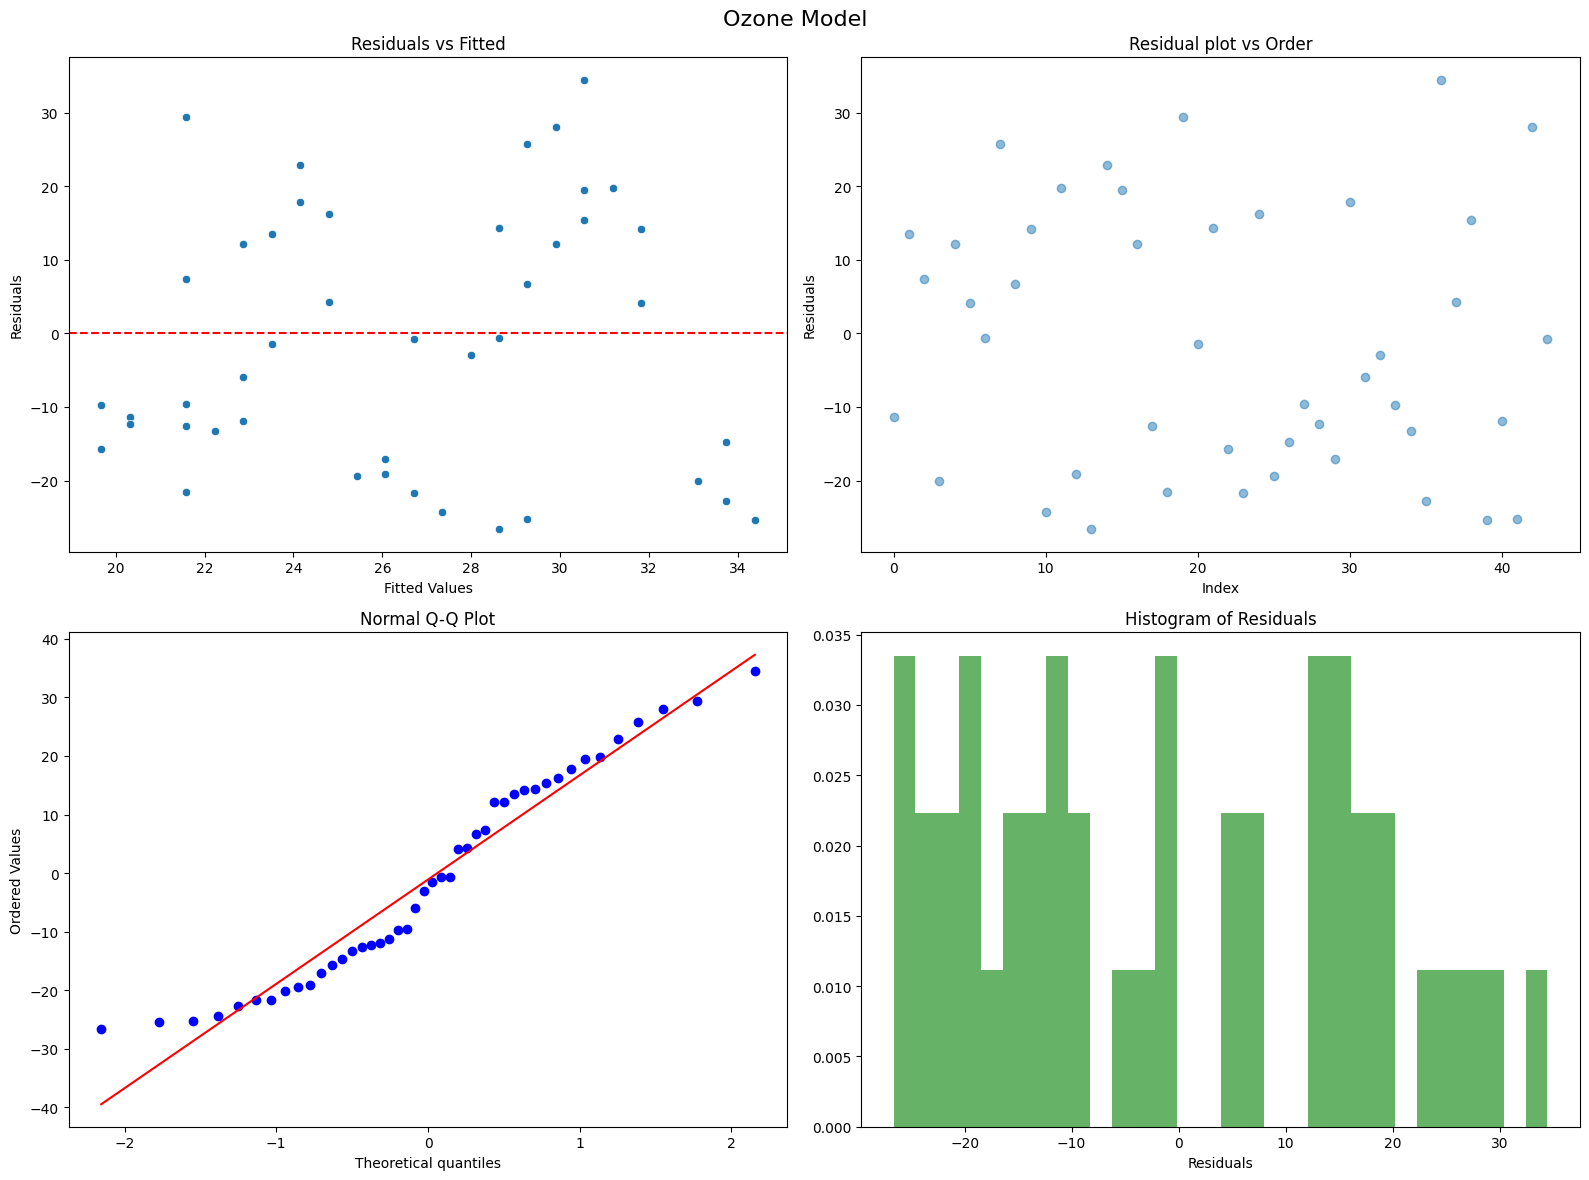

Model 2.1: Particulate Matter 10
Particulate Matter 10 Model - Mean Squared Error: 73.104
Particulate Matter 10 Model - R2: 0.24300000071525574


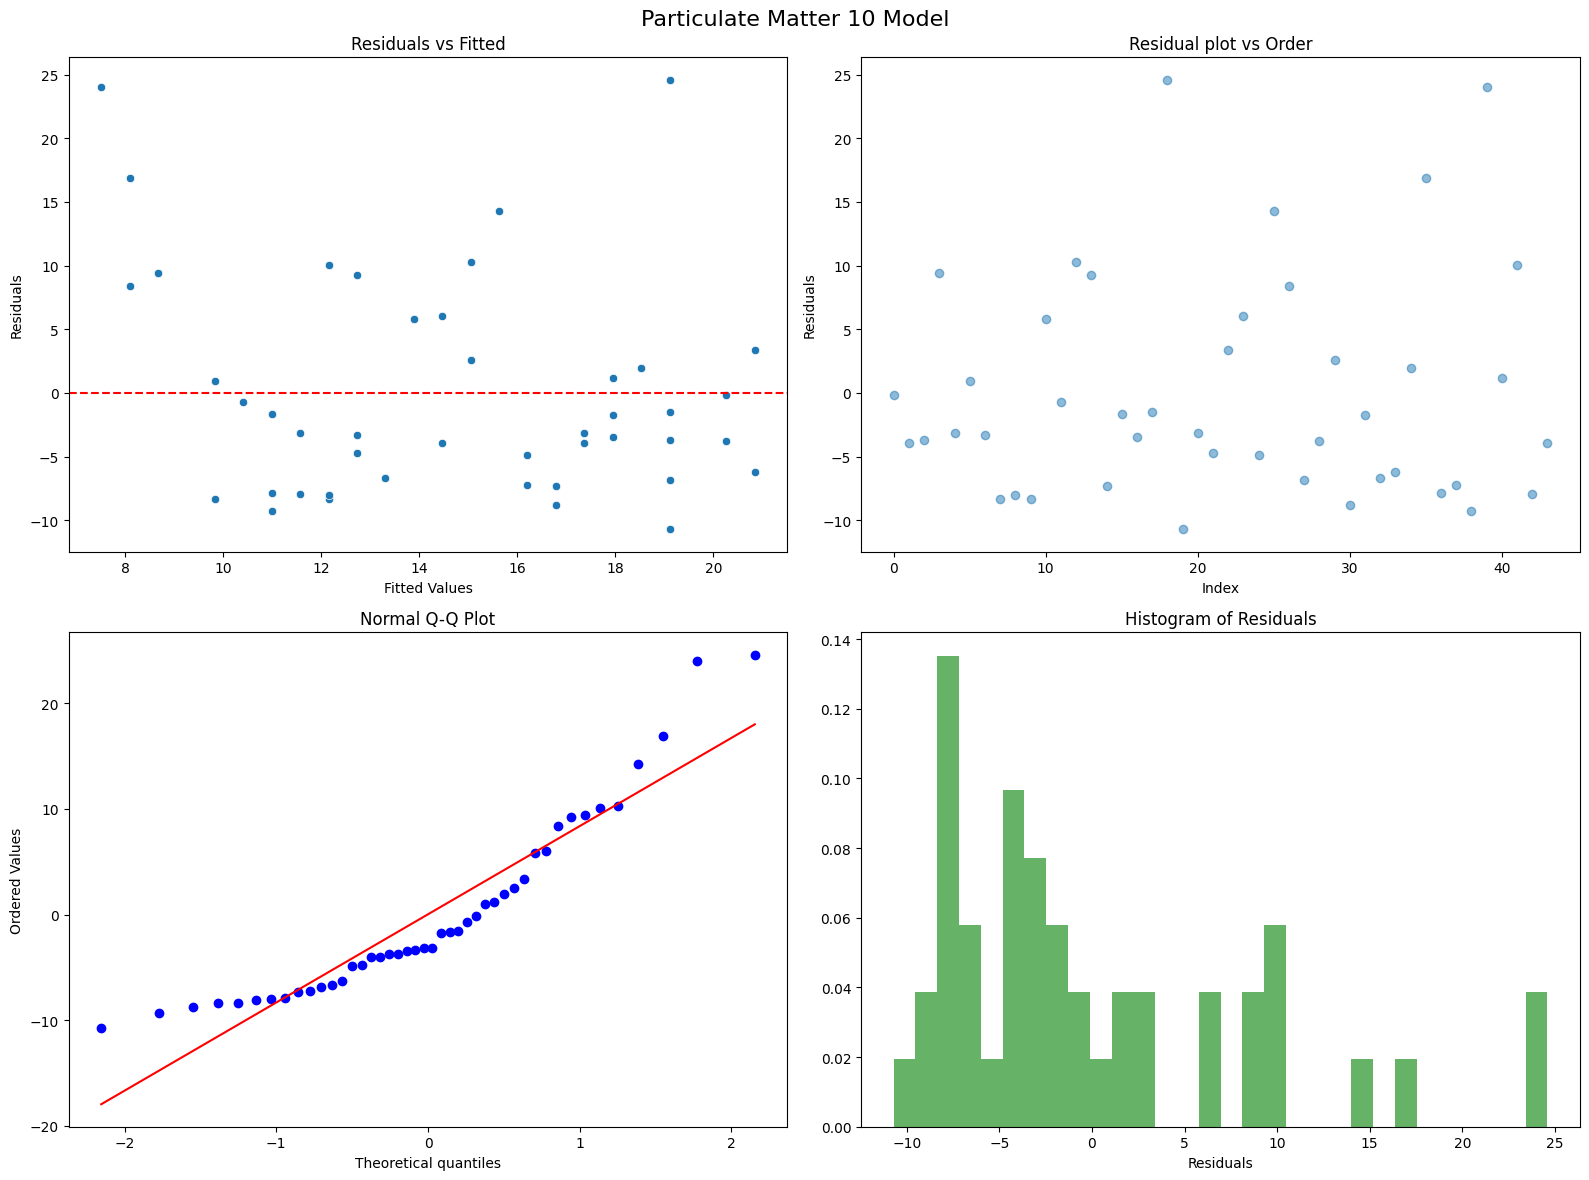

Model 2.2: Particulate Matter 2.5
Particulate Matter 2.5 - Mean Squared Error: 68.46
Particulate Matter 2.5 - R2: 0.2249000072479248


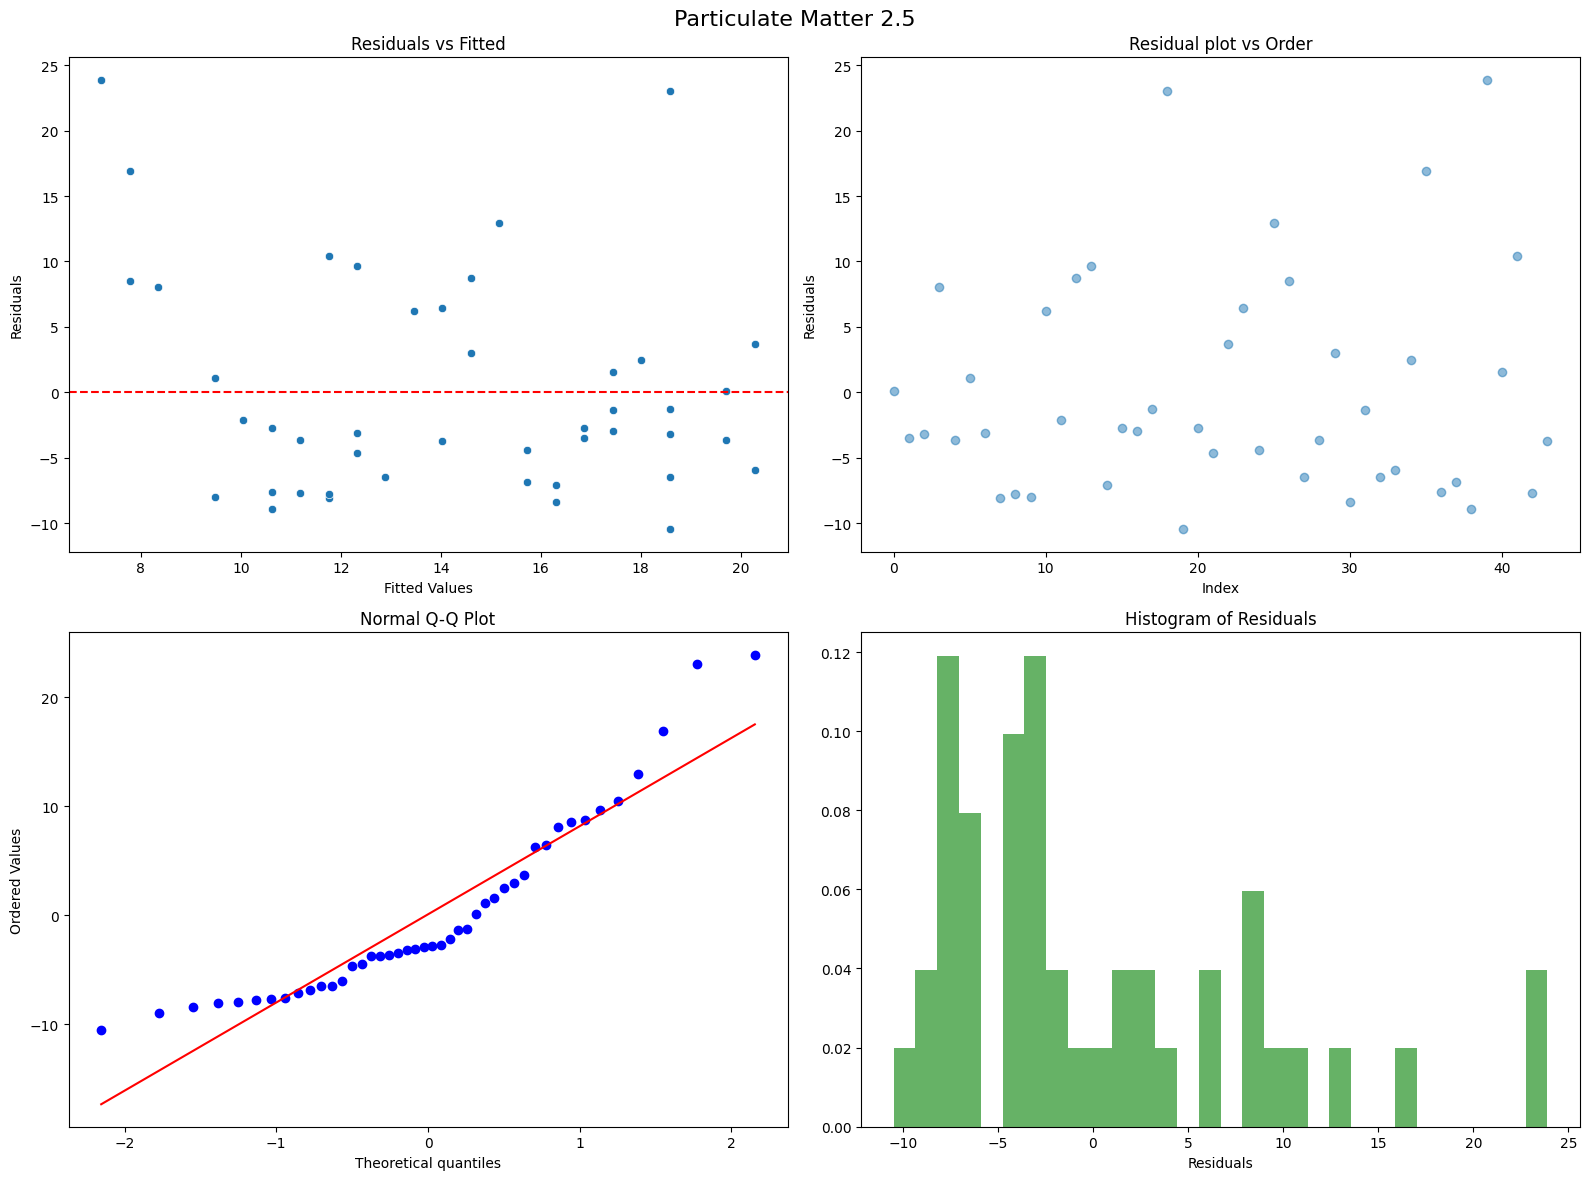

Model 3.1: Carbon Monoxide
Carbon Monoxide Model - Mean Squared Error: 12352.006
Carbon Monoxide Model - R2: -0.05609999969601631


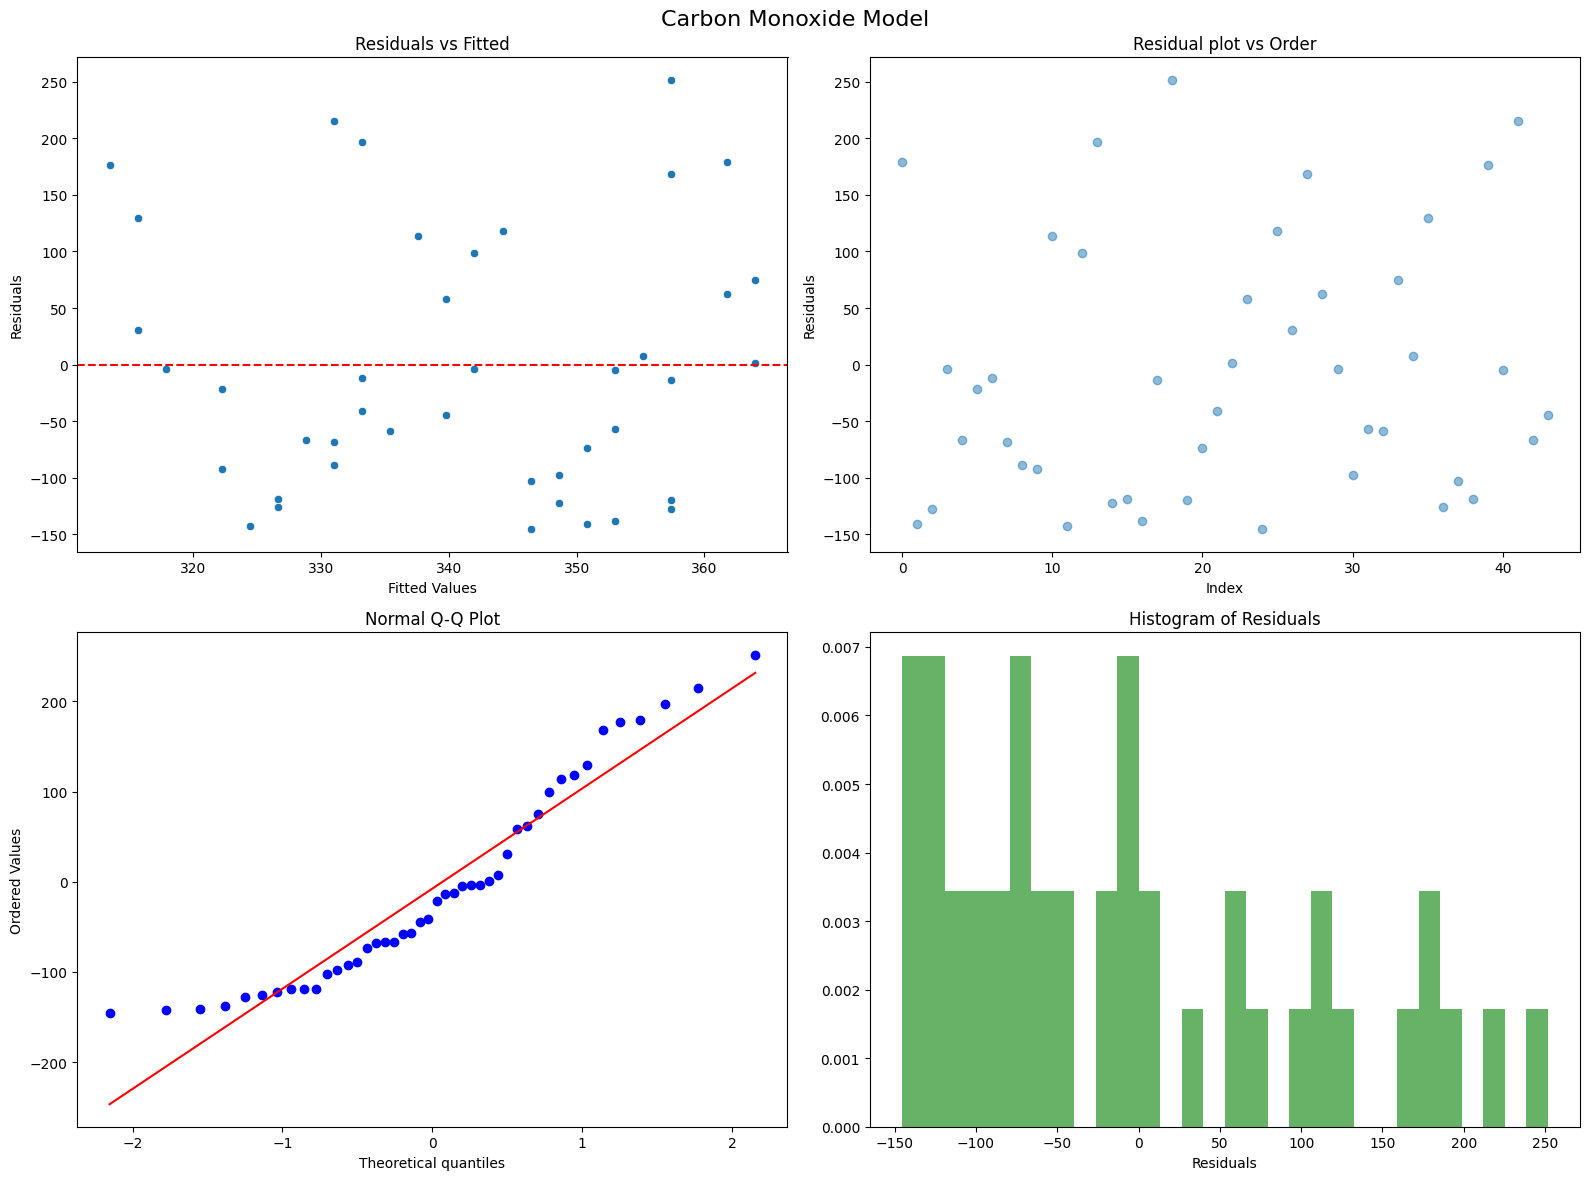

Model 3.2: Cardon Dioxide
Cardon Dioxide Model - Mean Squared Error: 275.62
Cardon Dioxide Model - R2: 0.02410000003874302


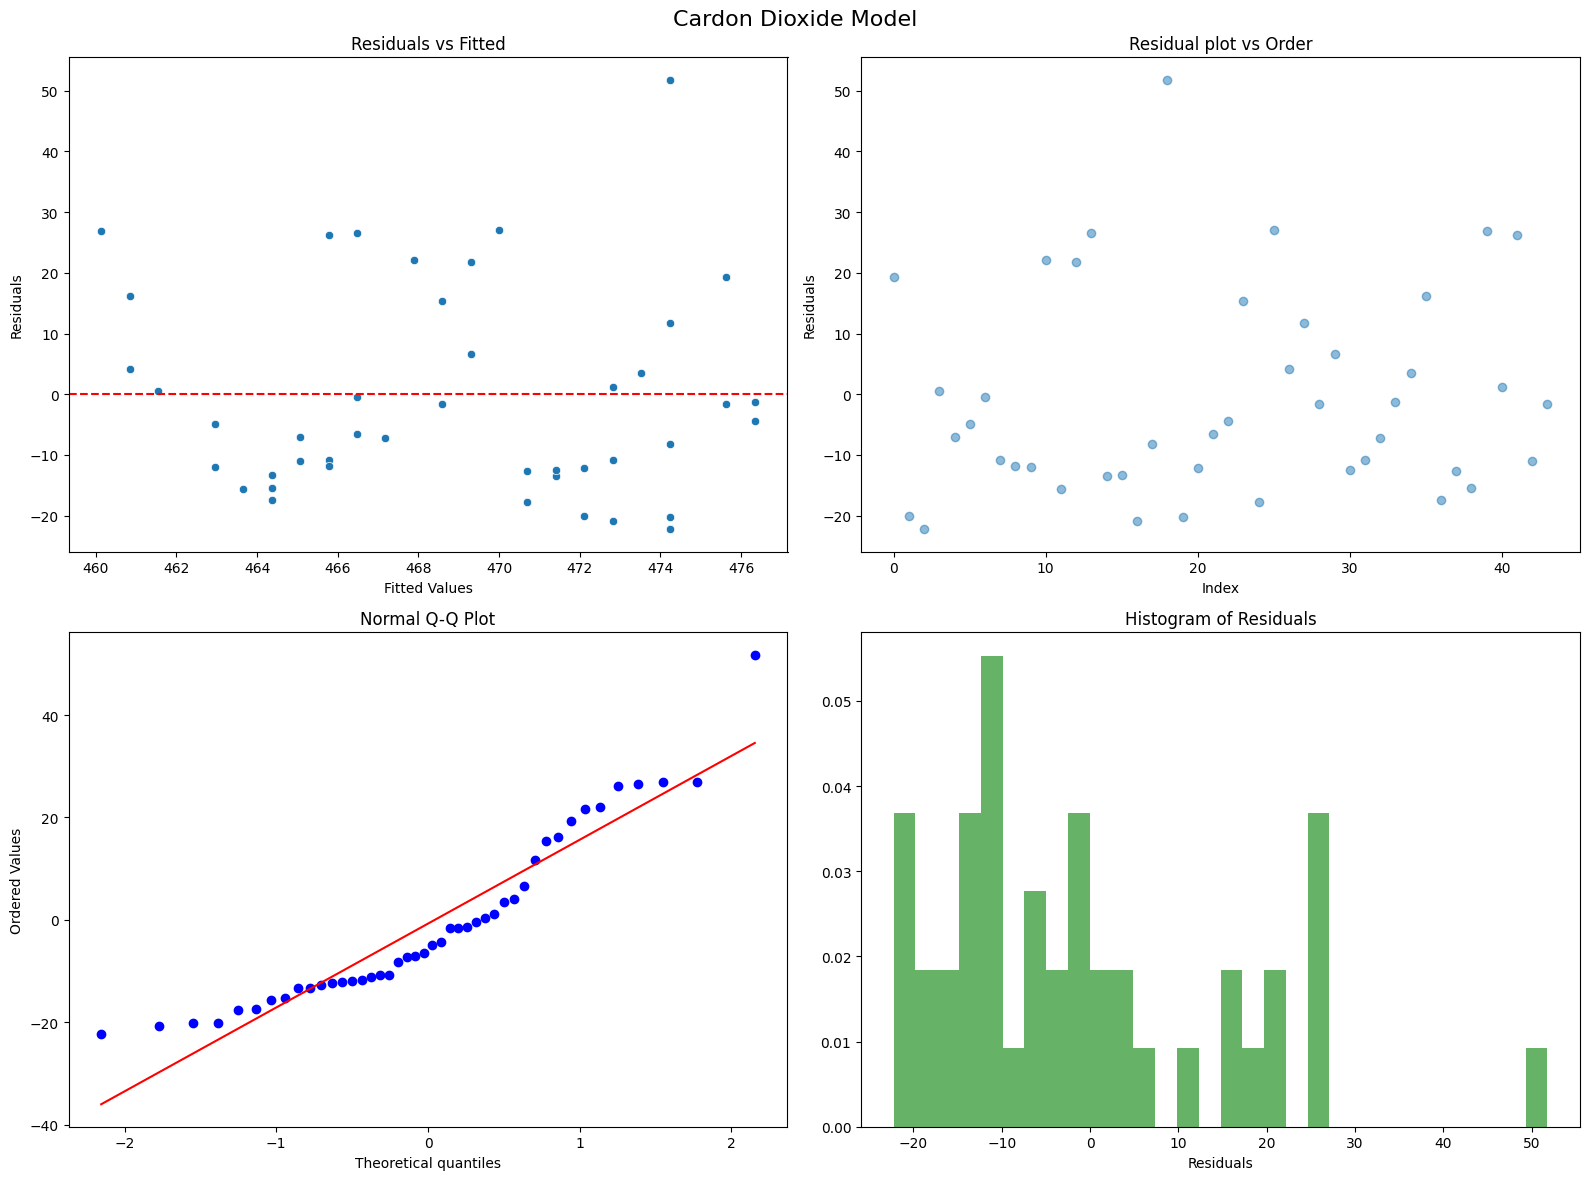

In [6]:
# Main function to answer the question
def main():
    """
    Returns:
        Evaluated models for each feature along with the graphs
    """
    df = preprocess_data(hourly_dataframe)
    # Model 1: Ozone
    print("Model 1: Ozone")
    X_ozone = df[['hour']]
    y_ozone = df['ozone']
    evaluate_model(X_ozone, y_ozone, "Ozone Model")

    # Model 2.1: Particulate Matter 10
    print("Model 2.1: Particulate Matter 10")
    X_pm10 = df[['hour']]
    y_pm10 = df['pm10']
    evaluate_model(X_pm10, y_pm10, "Particulate Matter 10 Model")

    # Model 2.2: Particulate Matter 2.5
    print("Model 2.2: Particulate Matter 2.5")
    X_pm2_5 = df[['hour']]
    y_pm2_5 = df['pm2_5']
    evaluate_model(X_pm2_5, y_pm2_5, "Particulate Matter 2.5")

    # Model 3.1: Carbon Monoxide
    print("Model 3.1: Carbon Monoxide")
    X_carbonm = df[['hour']]
    y_carbonm = df['carbon_monoxide']
    evaluate_model(X_carbonm, y_carbonm, "Carbon Monoxide Model")

    # Model 3.2: Carbon Dioxide
    print("Model 3.2: Cardon Dioxide")
    X_carbond = df[['hour']]
    y_carbond = df['carbon_dioxide']
    evaluate_model(X_carbond, y_carbond, "Cardon Dioxide Model")

# Run the main function
if __name__ == '__main__':
    main()

### Attempt 2 - Polynomial regression
#### Creating the Design Matrix

Using the `PolynomialFeatures` and `.fit_transform` functions to convert the `hour` ($x$) feature into an array (`X_hour_poly`) that includes columns corresponding to building a quartic model for `tripduration` ($y$) along the lines of: $y = \beta_0 + \beta_1 x + \beta_2 x^2 + \beta_3 x^3 + \beta_4 x^4$.

In [7]:
# preprocess the dataframe first
df = preprocess_data(hourly_dataframe)
df.head()

,date,pm10,pm2_5,carbon_monoxide,carbon_dioxide,ozone,started_at,hour
0,2025-11-19 00:00:00+00:00,15.3,15.3,240.0,451.0,24.0,2025-11-19 00:00:00+00:00,0
1,2025-11-19 01:00:00+00:00,15.3,15.3,241.0,452.0,25.0,2025-11-19 01:00:00+00:00,1
2,2025-11-19 02:00:00+00:00,15.5,15.5,236.0,452.0,27.0,2025-11-19 02:00:00+00:00,2
3,2025-11-19 03:00:00+00:00,15.4,15.4,230.0,452.0,29.0,2025-11-19 03:00:00+00:00,3
4,2025-11-19 04:00:00+00:00,15.0,15.0,223.0,452.0,32.0,2025-11-19 04:00:00+00:00,4


In [8]:
from sklearn.preprocessing import PolynomialFeatures
# prepare the data
X_hour = np.array(df['hour']).reshape(-1,1)
y = df['ozone']

In [9]:
# degree 4 for the quadratic equation
poly = PolynomialFeatures(degree=4)
# gets the X_poly with bias column in the beginning
X_poly_bias = poly.fit_transform(X_hour)
# removes the bias column
X_poly = X_poly_bias[:, 1:]
print(X_poly[0])

[0. 0. 0. 0.]


#### Cross Validation

Using single-fold cross validation with a 70-30 split, we create `Xtrain`, `Xtest`, `ytrain`, and `ytest` (from `X_poly` from Part 1.1 and `y` as defined before).

We fit the model using our own `line_of_best_fit` function to `Xtrain` and `ytrain`, using Numpy.

Then we pass `Xtest`, `ytest`, and the output from the `line_of_best_fit` to our `linreg_predict` function.

Finally, we print out the cross-validated $MSE$ and $R^2$ values.

In [10]:
def add_bias_column(X):
    """ adds a bias columm
    Args:
        X (array): can be either 1-d or 2-d

    Returns:
        Xnew (array): the same array, but 2-d with a column of 1's in the first spot
    """

    # If the array is 1-d
    if len(X.shape) == 1:
        Xnew = np.column_stack([np.ones(X.shape[0]), X])

    # If the array is 2-d
    elif len(X.shape) == 2:
        bias_col = np.ones((X.shape[0], 1))
        Xnew = np.hstack([bias_col, X])

    else:
        raise ValueError("Input array must be either 1-d or 2-d")

    return Xnew

In [11]:
def line_of_best_fit(X, y):
    """ returns a vector containing the coefficients for the line of best fit, including an intercept term
    Args:
        X (array): either 1-d or 2-d which includes all the predictor values, not including bias term
        y (array): a 1-d array which includes all corresponding response values to X

    Returns:
        m (array): the vector containing the coefficients for the line of best fit, including an intercept term
    """
    # adds a bias column to X
    X_new = add_bias_column(X)
    # calculates the line of best fit
    XtXinv = np.linalg.inv(np.matmul(X_new.T, X_new))
    m = np.matmul(XtXinv, np.matmul(X_new.T, y))
    return m

In [12]:
from sklearn.metrics import r2_score

In [13]:
def linreg_predict(Xnew, ynew, m):
    """ returns a dictionary containing: the predicted values from applying m to Xnew, the residuals,
    the mean squared error, and the coefficient of determination

    Args:
        Xnew (array): an array, either 1-d or 2-d which includes all the predictor features, not including bias term
        ynew (array): a 1-d array which includes all corresponding response values to Xnew
        m (array): a 1-d array of length which contains the coefficients from the line_of_best_fit function

    Returns:
        output_dict (dictionary): a dictionary that has:
            - 'ypreds' (the predicted values from applying m to Xnew)
            - 'resids' (the residuals, the differences between ynew and ypreds)
            - 'mse' (the mean squared error)
            - 'r2' (the coefficient of determination representing the proportion of variability in ynew explained by the line of best fit
    """
    # initializes an output dictionary for required values
    output_dict = {}
    # adds a bias column to the Xnew array
    Xnew_bias_added = add_bias_column(Xnew)
    # calculates the line of best fit for Xnew with bias and ynew
    # gets the predicted values from applying m to Xnew
    ypreds = np.matmul(Xnew_bias_added, m)
    # gets the residuals
    res = ynew - ypreds
    # gets the mean squared error
    mse = (res**2).mean()
    # gets the R^2
    r2 = r2_score(ynew, ypreds)
    # adds values to the dictionary
    output_dict['ypreds'] = ypreds
    output_dict['resids'] = res
    output_dict['mse'] = mse
    output_dict['r2'] = r2
    return output_dict

In [14]:
# single-fold cross validation
crossval = train_test_split(X_poly, y, test_size=0.3, random_state=3)
Xtrain, Xtest, ytrain, ytest = crossval

# finds the line of best fit
m = line_of_best_fit(Xtrain, ytrain)
model = linreg_predict(Xtest, ytest, m)

# prints out MSE and R^2 values
print('MSE for the first poly regression model = ', model['mse'].round(3))
print('R^2 for the first poly regression model = ', round(model['r2'], 4))

MSE for the first poly regression model =  245.537
R^2 for the first poly regression model =  0.2712


Polynominal Regression Model 1: Ozone
Ozone Model (Degree = 4) - Mean Squared Error: 245.537
Ozone Model (Degree = 4) - R2: 0.18960000574588776


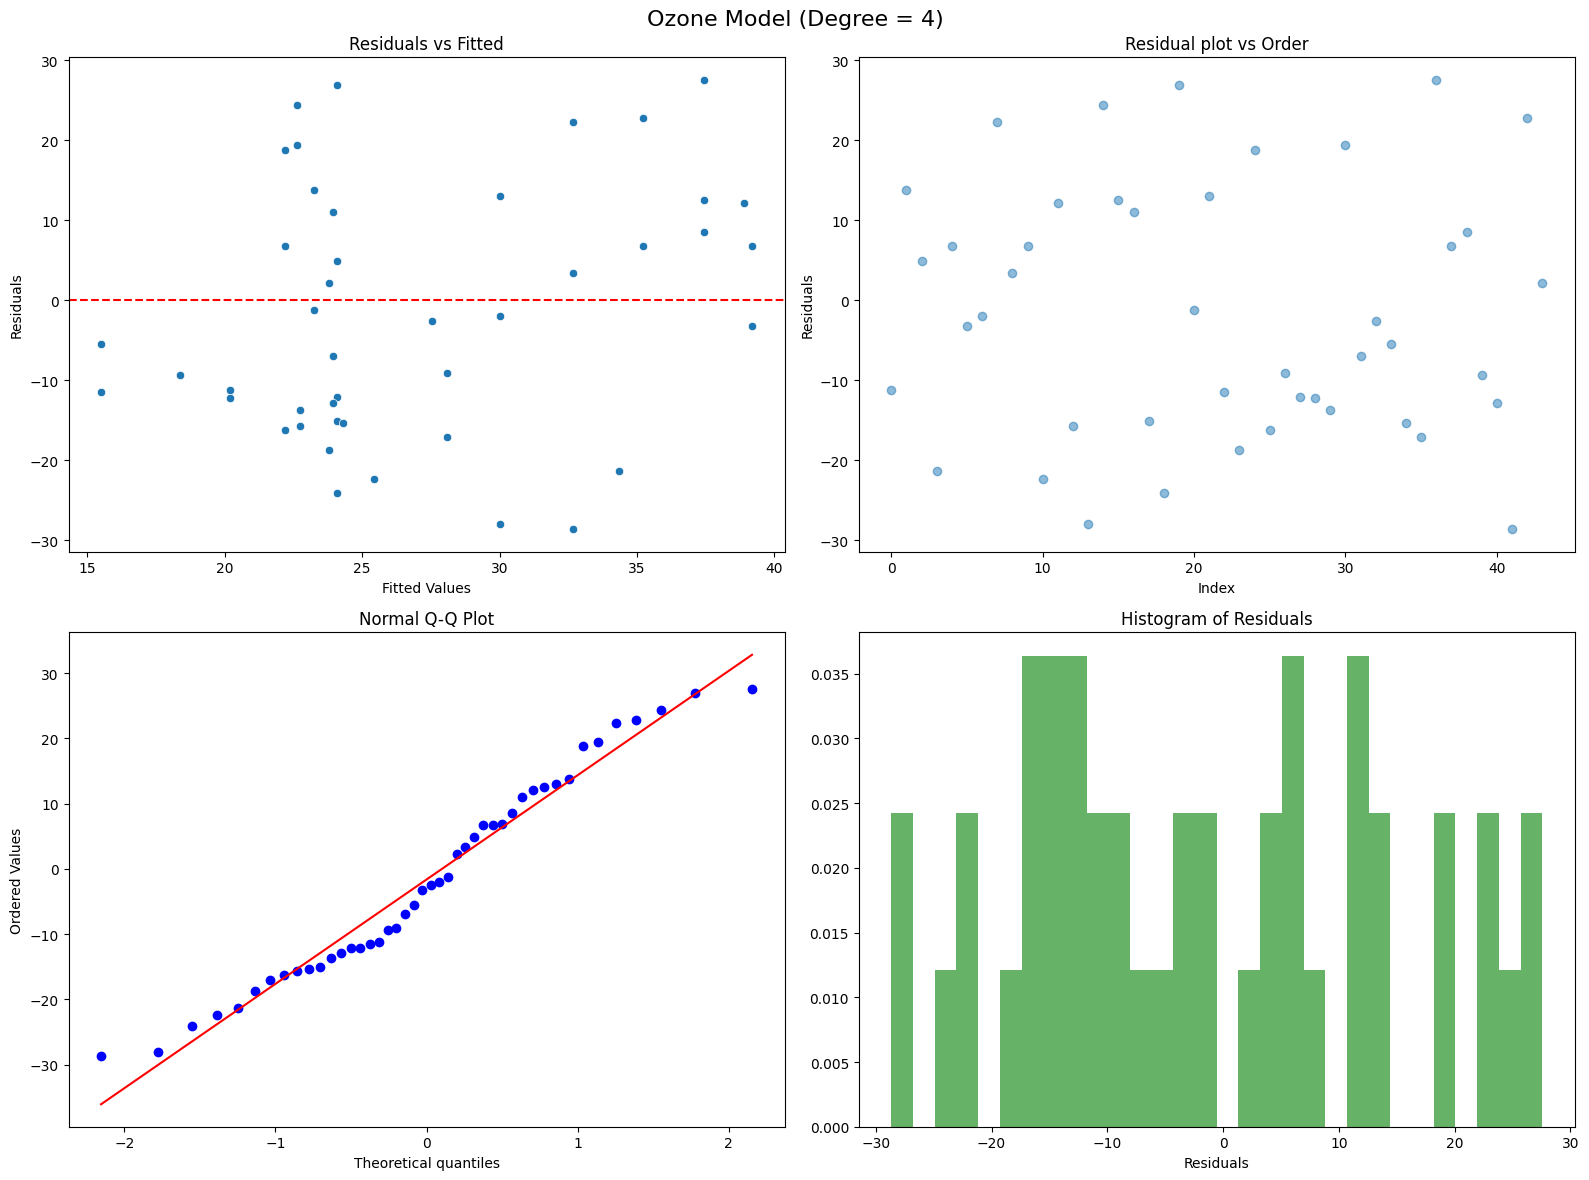

Polynominal Regression Model 2.1: Particulate Matter 10
Particulate Matter 10 Model (Degree = 4) - Mean Squared Error: 60.826
Particulate Matter 10 Model (Degree = 4) - R2: 0.3700999915599823


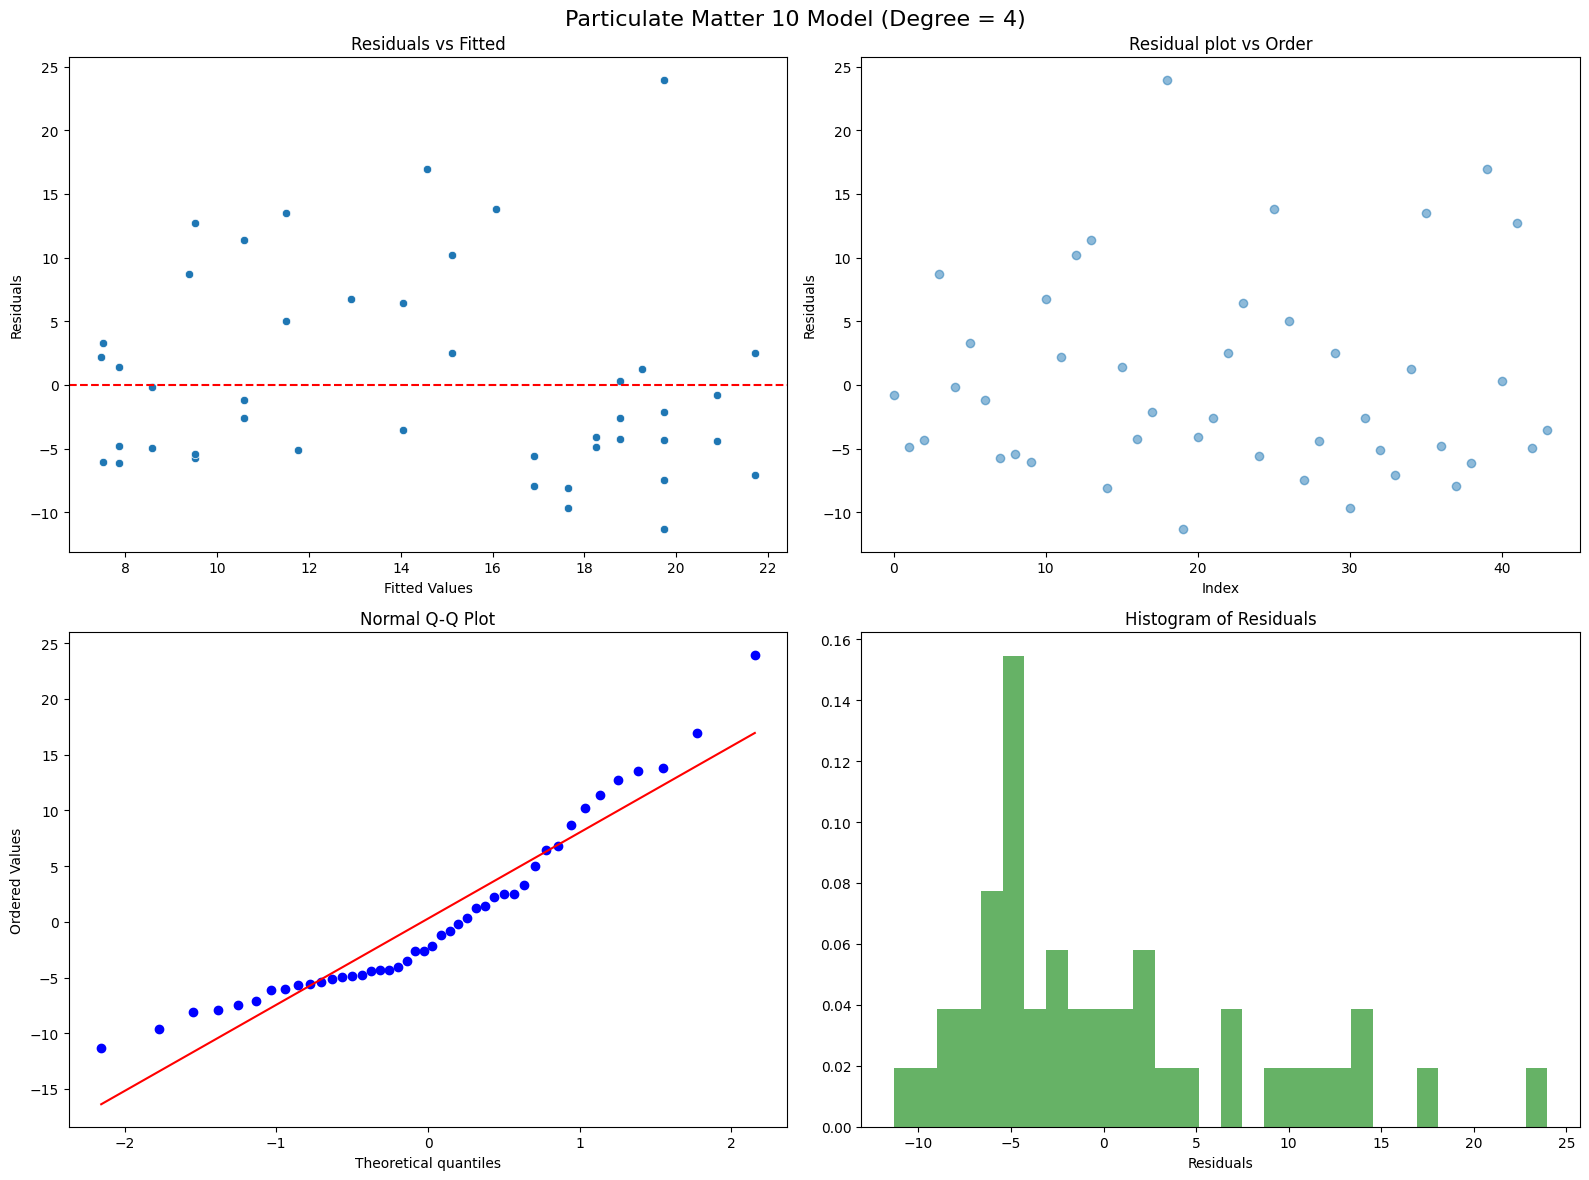

Polynominal Regression Model 2.2: Particulate Matter 2.5
Particulate Matter 2.5 (Degree = 4) - Mean Squared Error: 56.28
Particulate Matter 2.5 (Degree = 4) - R2: 0.3628000020980835


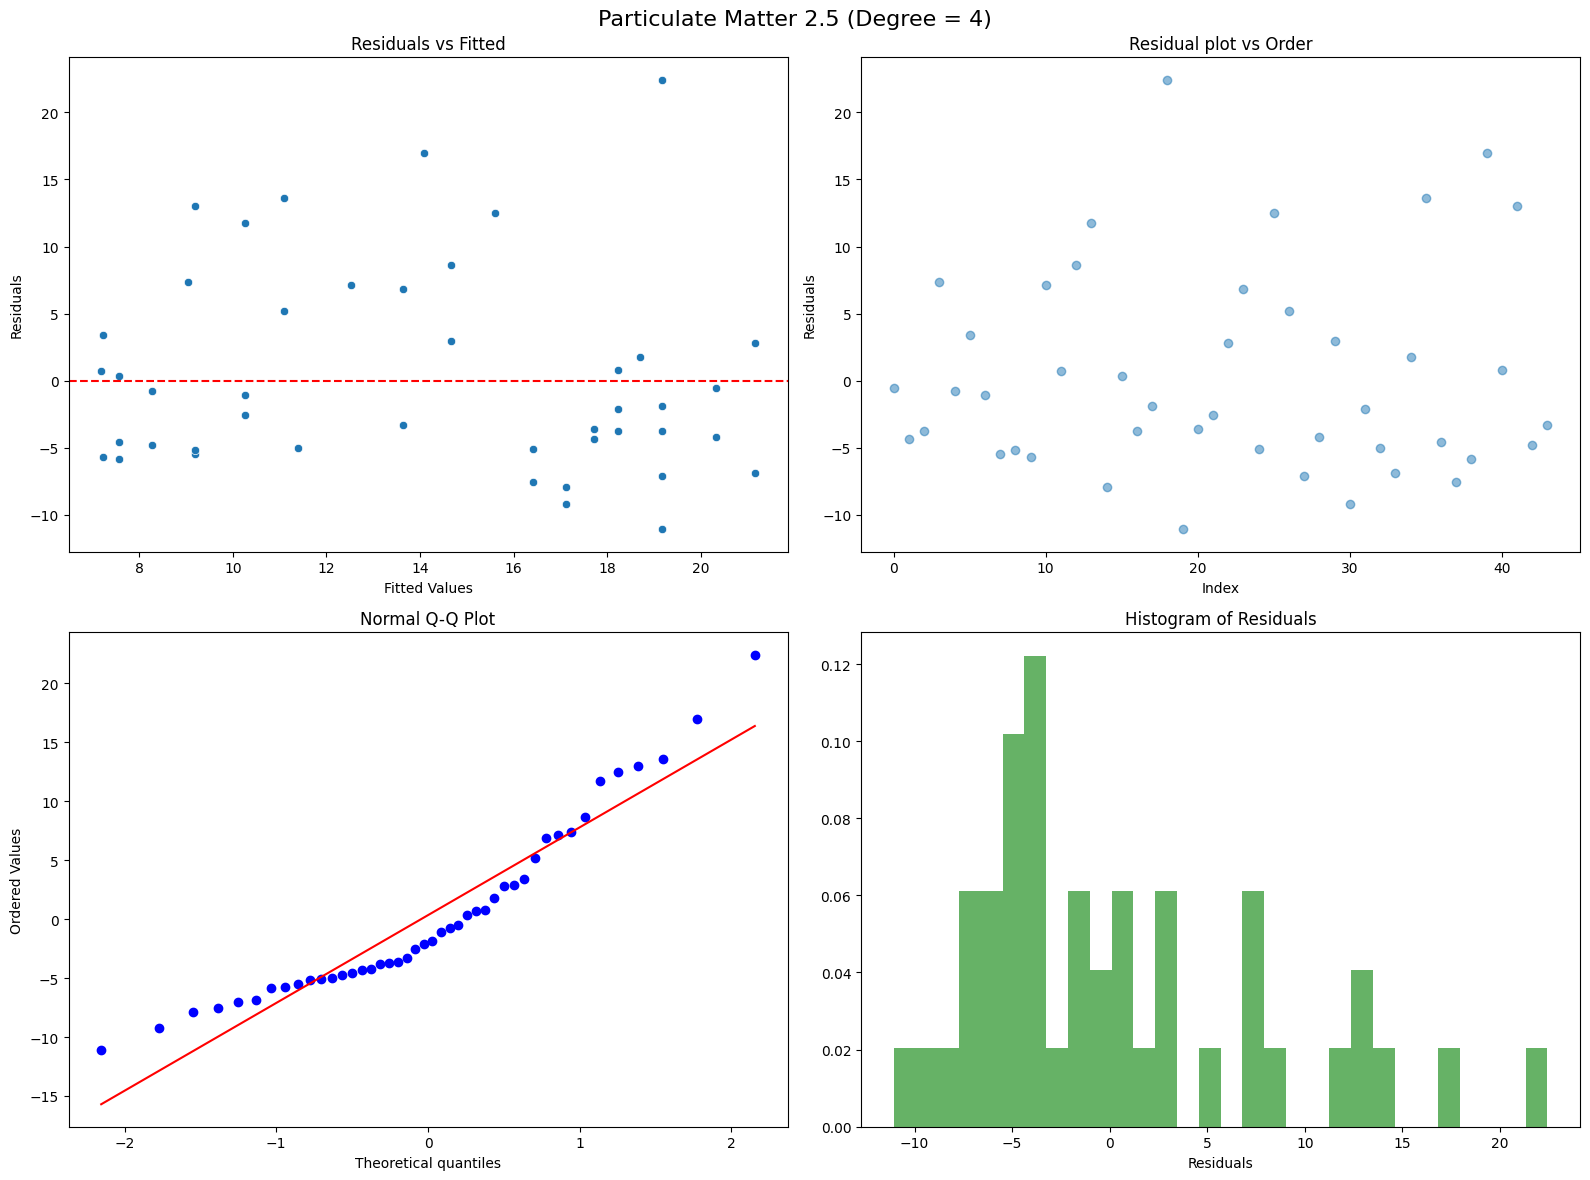

Polynominal Regression Model 3.1: Carbon Monoxide
Carbon Monoxide Model (Degree = 4) - Mean Squared Error: 11167.836
Carbon Monoxide Model (Degree = 4) - R2: 0.045099999755620956


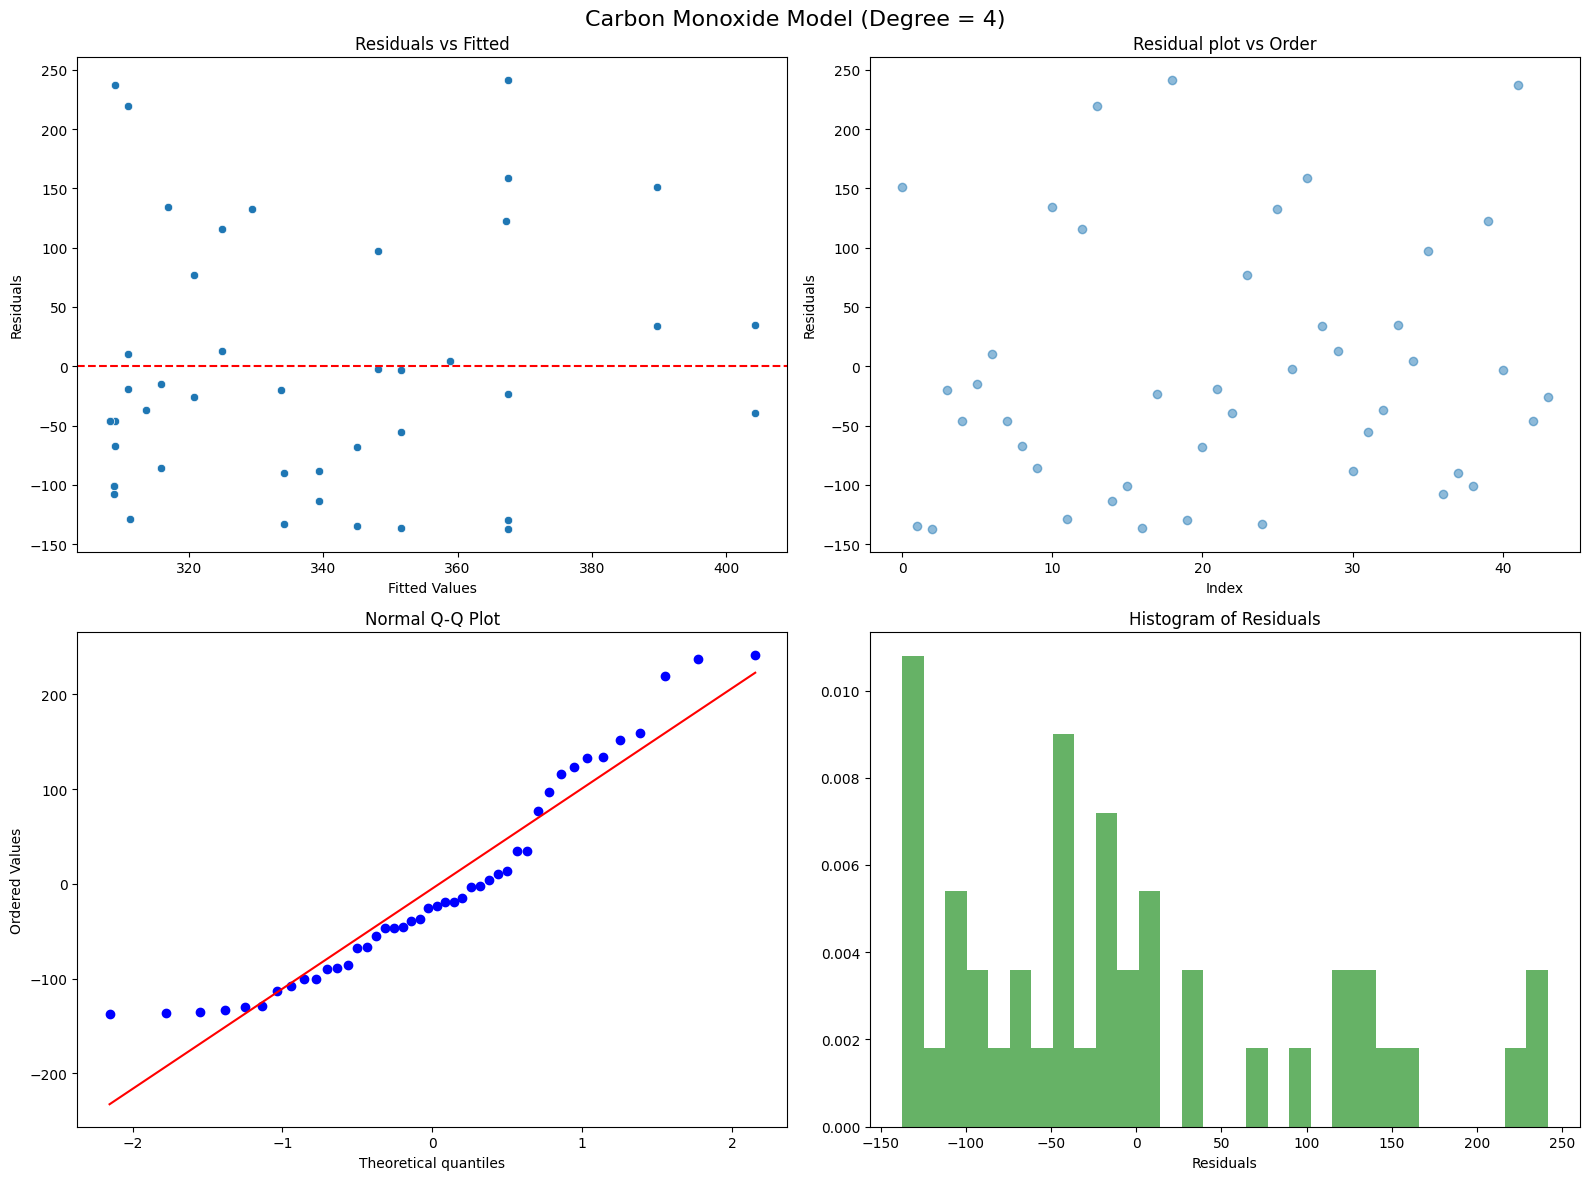

Polynominal Regression Model 3.2: Cardon Dioxide
Cardon Dioxide Model (Degree = 4) - Mean Squared Error: 263.025
Cardon Dioxide Model (Degree = 4) - R2: 0.06870000064373016


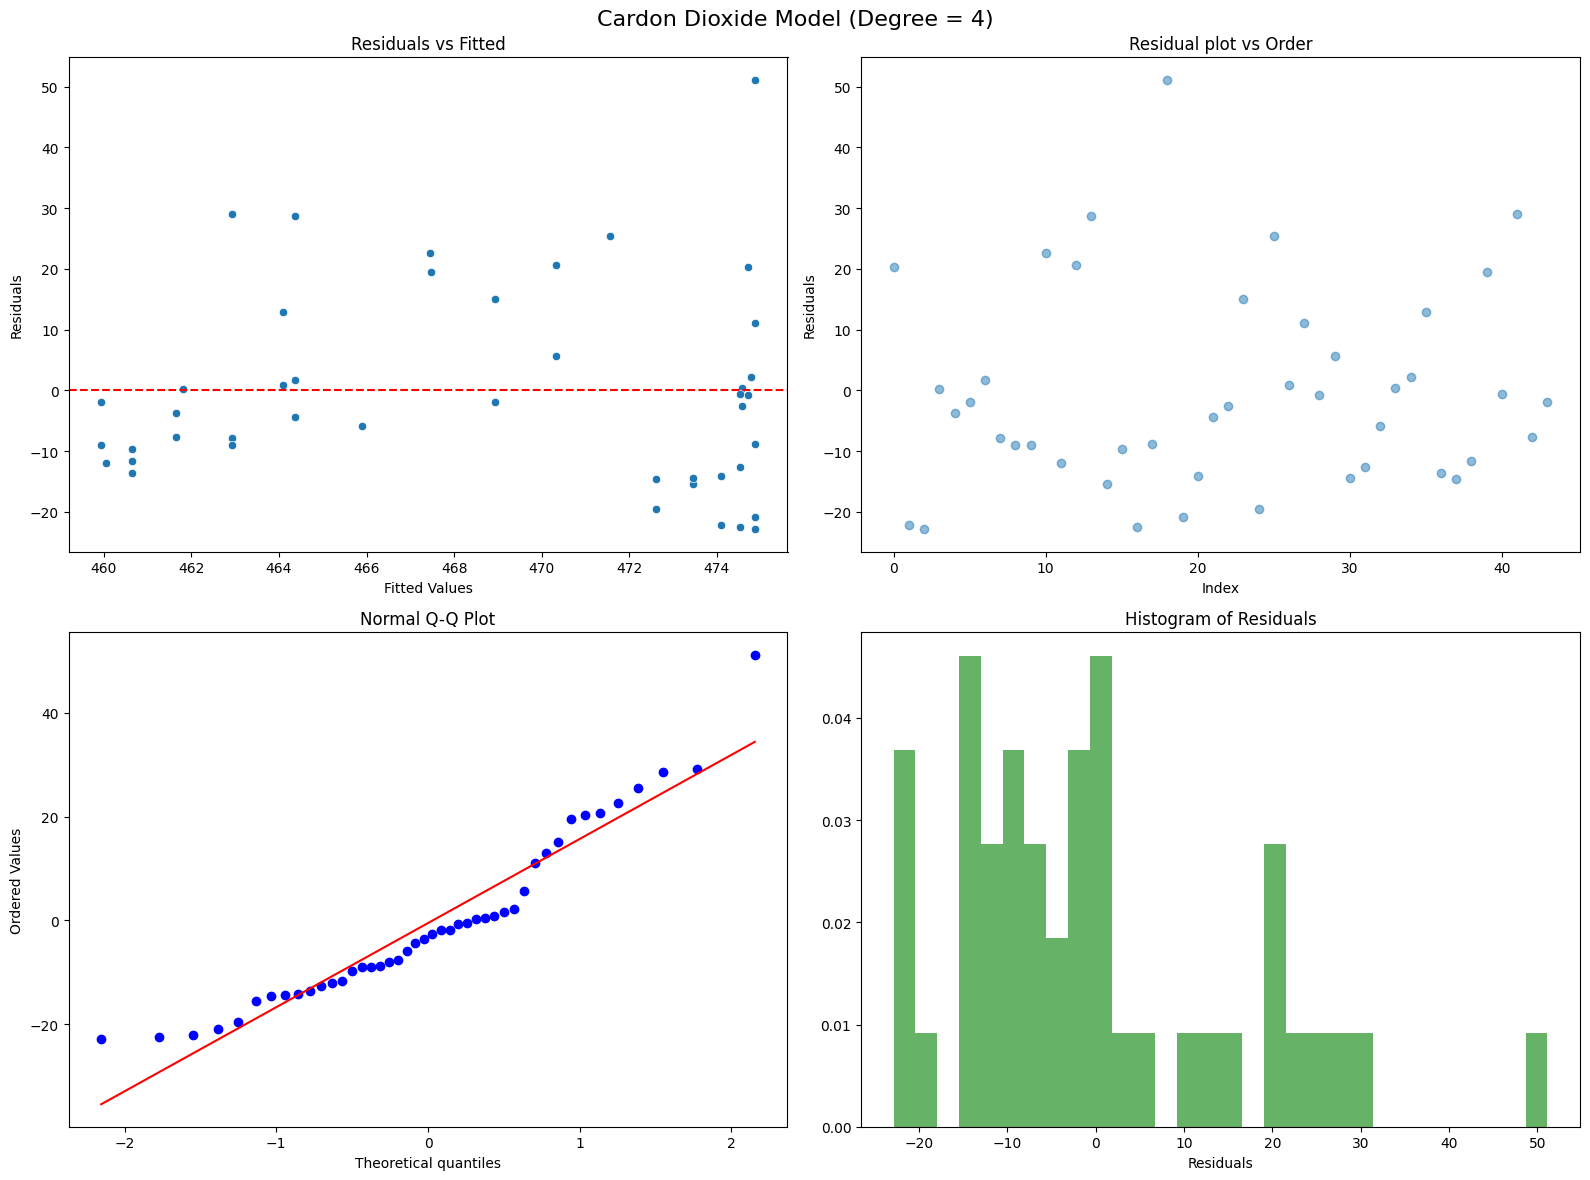

In [15]:
# Main function to answer the question
def poly_main():
    """
    Returns:
        Evaluated models for polynomial regression model for each feature along with the graphs
    """
    df = preprocess_data(hourly_dataframe)

    # Model 1: Ozone
    print("Polynominal Regression Model 1: Ozone")
    X_ozone = poly.fit_transform(df[['hour']])
    y_ozone = df['ozone']
    evaluate_model(X_ozone, y_ozone, "Ozone Model (Degree = 4)")

    # Model 2.1: Particulate Matter 10
    print("Polynominal Regression Model 2.1: Particulate Matter 10")
    X_pm10 = poly.fit_transform(df[['hour']])
    y_pm10 = df['pm10']
    evaluate_model(X_pm10, y_pm10, "Particulate Matter 10 Model (Degree = 4)")

    # Model 2.2: Particulate Matter 2.5
    print("Polynominal Regression Model 2.2: Particulate Matter 2.5")
    X_pm2_5 = poly.fit_transform(df[['hour']])
    y_pm2_5 = df['pm2_5']
    evaluate_model(X_pm2_5, y_pm2_5, "Particulate Matter 2.5 (Degree = 4)")

    # Model 3.1: Carbon Monoxide
    print("Polynominal Regression Model 3.1: Carbon Monoxide")
    X_carbonm = poly.fit_transform(df[['hour']])
    y_carbonm = df['carbon_monoxide']
    evaluate_model(X_carbonm, y_carbonm, "Carbon Monoxide Model (Degree = 4)")

    # Model 3.2: Carbon Dioxide
    print("Polynominal Regression Model 3.2: Cardon Dioxide")
    X_carbond = poly.fit_transform(df[['hour']])
    y_carbond = df['carbon_dioxide']
    evaluate_model(X_carbond, y_carbond, "Cardon Dioxide Model (Degree = 4)")

# Run the main function
if __name__ == '__main__':
    poly_main()

### Attempt 3 - Polynomial Regression with added interaction terms and dummy variables
#### Creating Fitting Model

$$
y = b_0 + b_1 x_1 + b_2 x_1^2 + b_3 x_1^3 + b_4 x_1^4 + b_5x_1x_3 + b_6x_2x_4 + b_7x_1x_4 + b_8x_2x_3
$$

Where:

- $y$: air quality indicator
- $x_1$: hour
- $x_2$: day or night (1 or 0)

- Polynomial terms $b_0 + b_1 x_1 + b_2 x_1^2 + b_3 x_1^3 + b_4 x_1^4$
- Interaction terms with dummy variables $b_5x_1x_3 + b_6x_2x_4 + b_7x_1x_4 + b_8x_2x_3$

In [16]:
def categorize_hour(x):
    """
    Returns:
        label categorizing day or night
    """
    if x < 13:
        return 'day'
    else:
        return 'night'

In [17]:
# Prepares the hour data
X_hour = np.array(df['hour']).reshape(-1,1)
df['hour_label'] = df['hour'].apply(categorize_hour)
X_hour_type = df['hour_label'].astype('category').cat.codes.values.reshape(-1, 1)

# degree 4 for the quadratic equation
poly = PolynomialFeatures(degree=4)
# gets the X_poly with bias column in the beginning
X_hour_poly_bias = poly.fit_transform(X_hour)
# removes the bias column
X_hour_poly = X_hour_poly_bias[:, 1:]

# Combines X_hour_poly with interaction terms and dummy variables
X_poly = np.concatenate([
    X_hour_poly,
    X_hour_poly * X_hour_type,
    X_hour_poly * (1 - X_hour_type),
], axis=1)

print(X_poly[0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [18]:
# single-fold cross validation
crossval = train_test_split(X_poly, y, test_size=0.3, random_state=3)
Xtrain, Xtest, ytrain, ytest = crossval

# finds the line of best fit
m = line_of_best_fit(Xtrain, ytrain)
model = linreg_predict(Xtest, ytest, m)

# prints out MSE and R^2 values
print('MSE for the second poly regression model =', model['mse'].round(3))
print('R^2 for the second poly regression model =', round(model['r2'], 4))

MSE for the second poly regression model = 27685.64
R^2 for the second poly regression model = -81.173


Polynominal Regression Model 1: Ozone (with added interaction/dummy variables)
Ozone Model (Degree = 4, With Interactions) - Mean Squared Error: 217.791
Ozone Model (Degree = 4, With Interactions) - R2: 0.28119999170303345


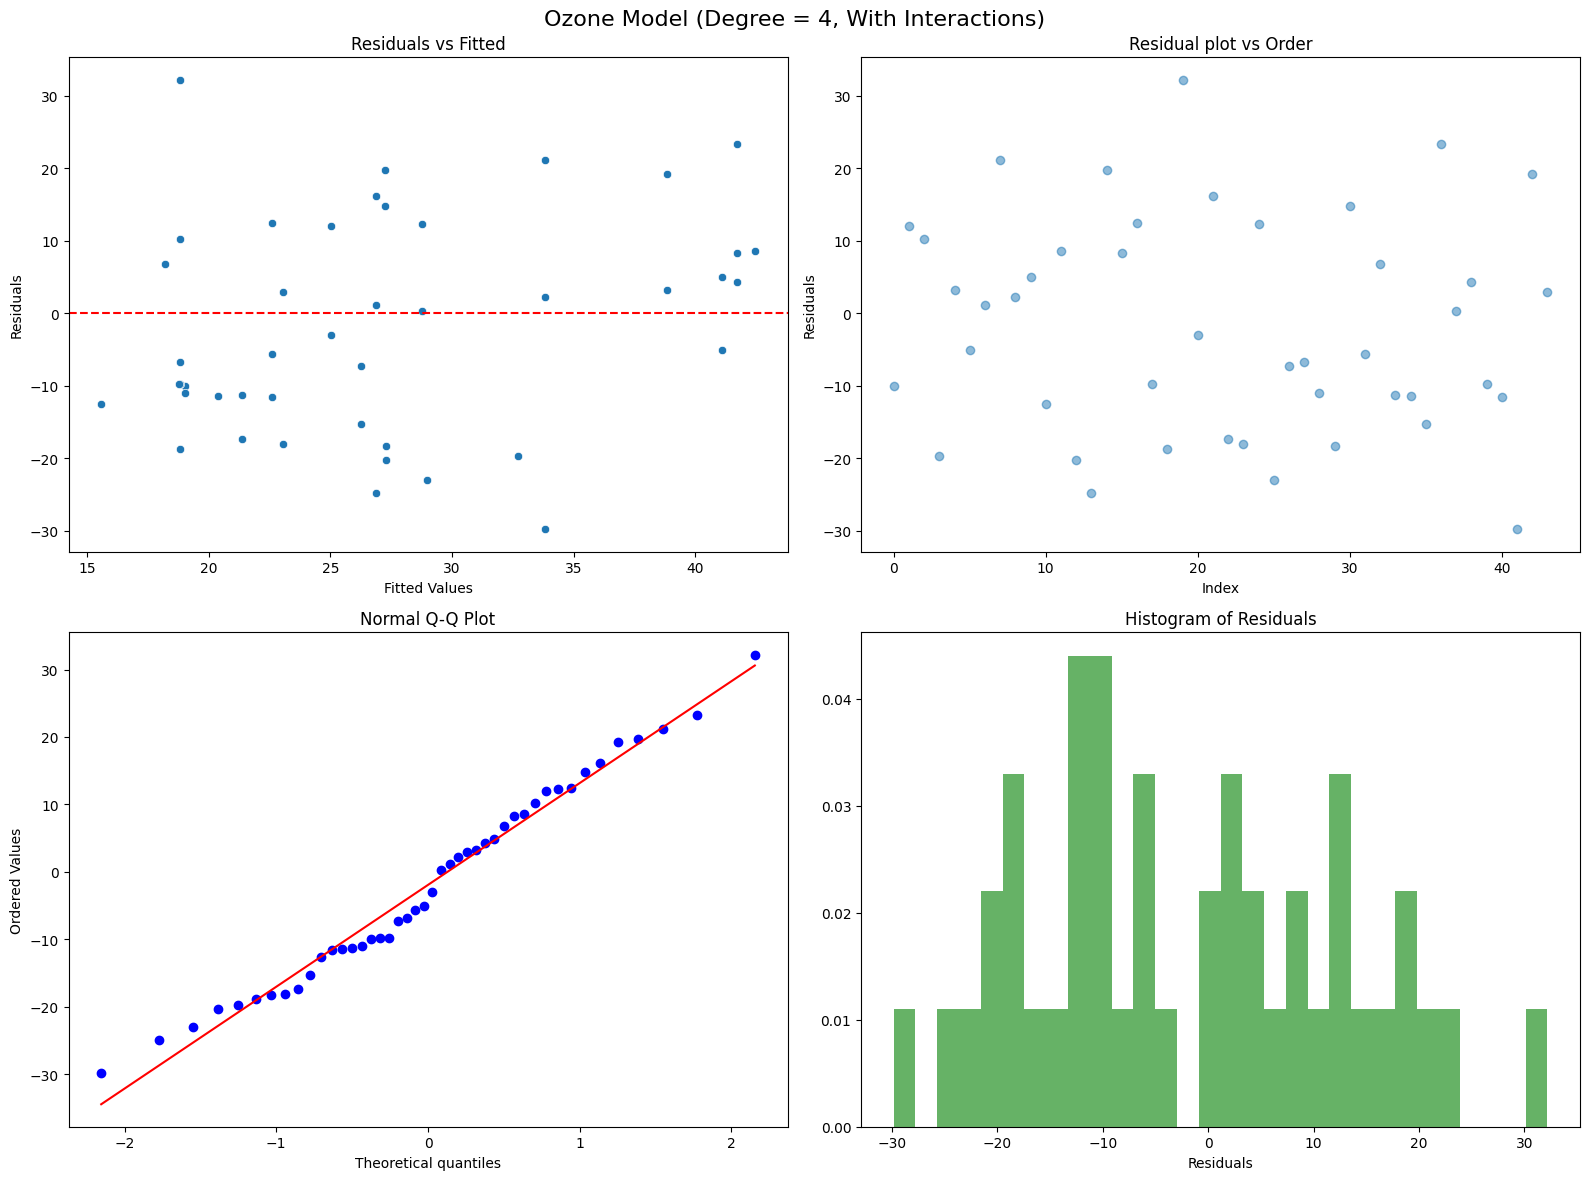

Polynominal Regression Model 2.1: Particulate Matter 10 (with added interaction/dummy variables)
Particulate Matter 10 Model (Degree = 4, With Interactions) - Mean Squared Error: 69.16
Particulate Matter 10 Model (Degree = 4, With Interactions) - R2: 0.28380000591278076


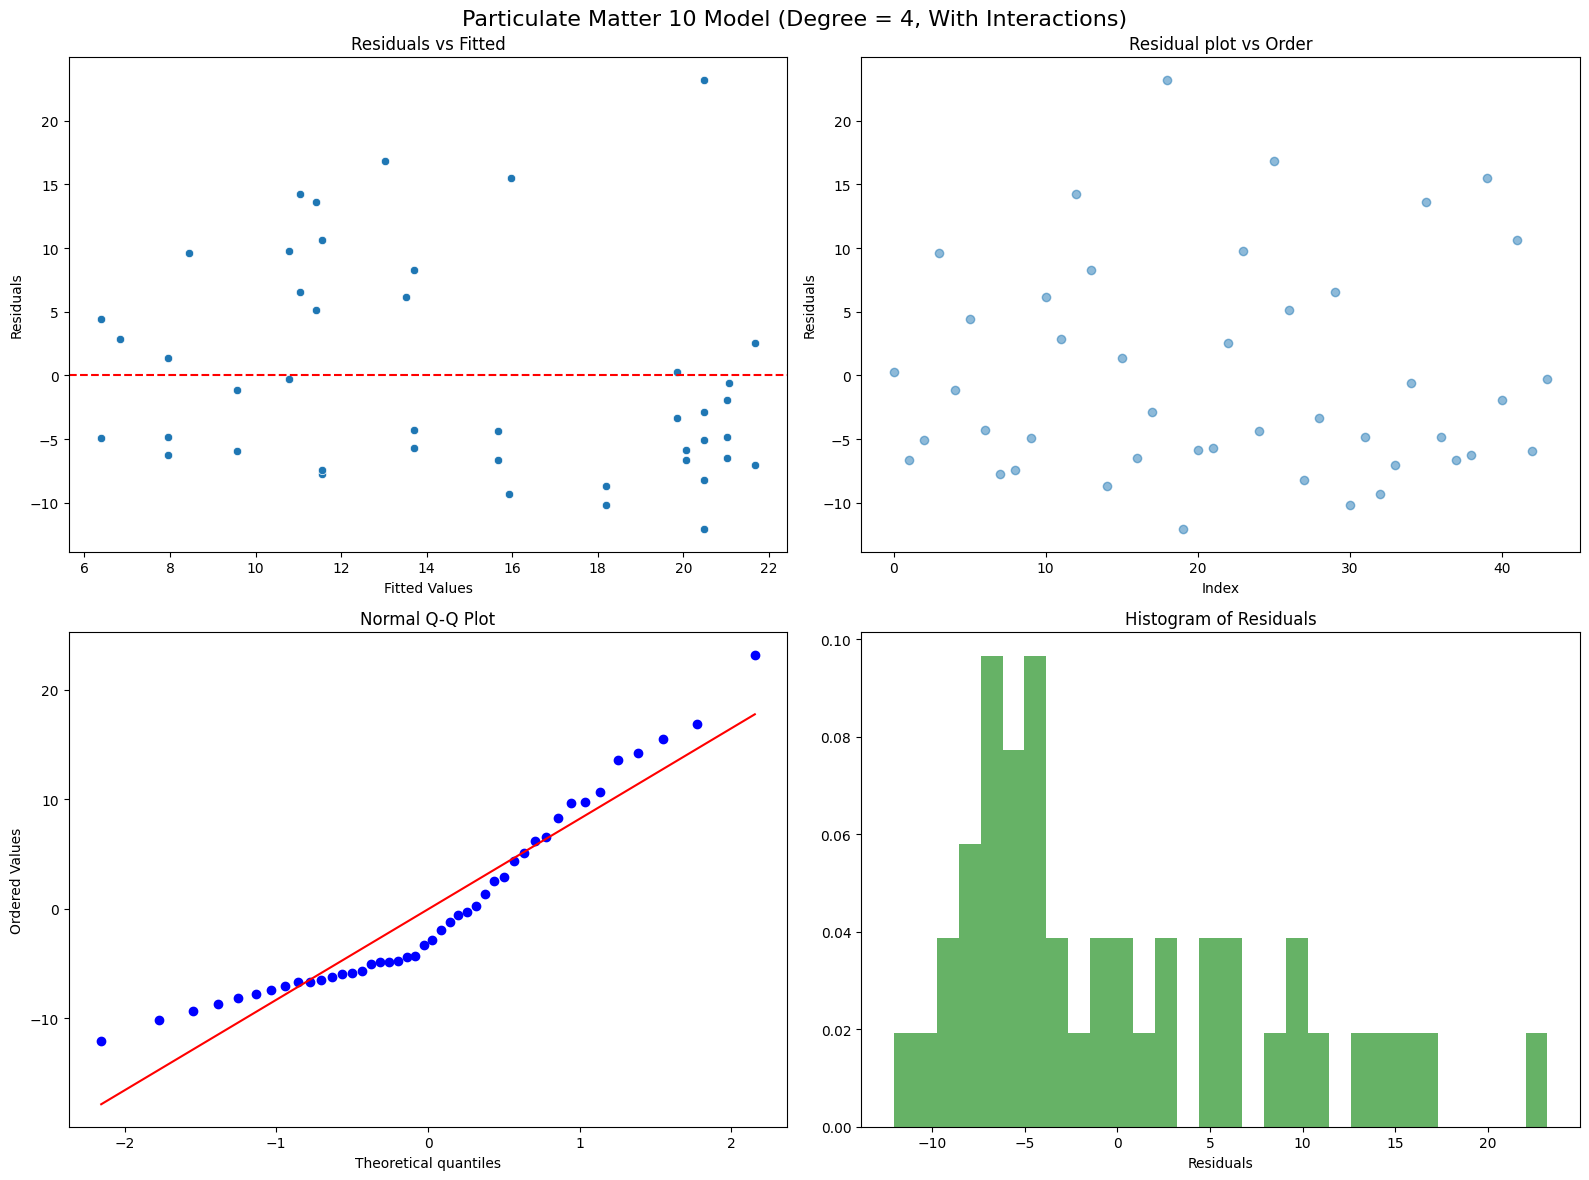

Polynominal Regression Model 2.2: Particulate Matter 2.5 (with added interaction/dummy variables)
Particulate Matter 2.5 (Degree = 4, With Interactions) - Mean Squared Error: 63.374
Particulate Matter 2.5 (Degree = 4, With Interactions) - R2: 0.2824999988079071


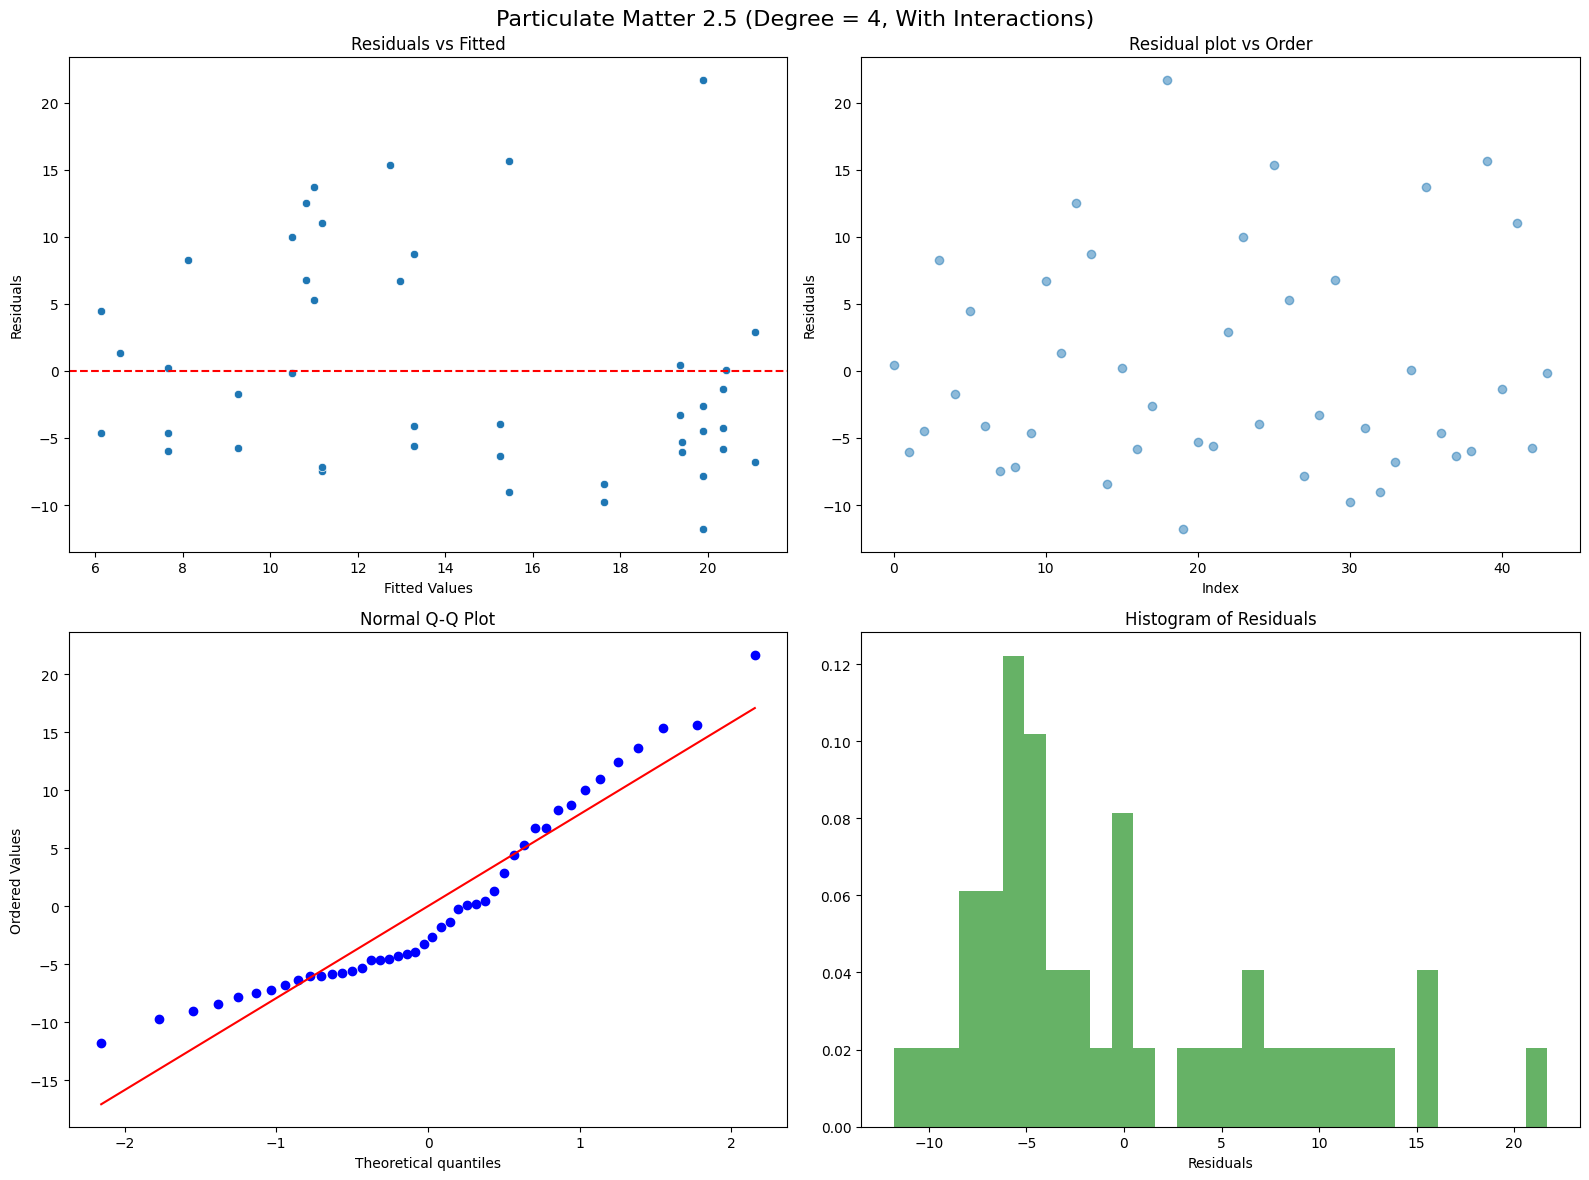

Polynominal Regression Model 3.1: Carbon Monoxide (with added interaction/dummy variables)
Carbon Monoxide Model (Degree = 4, With Interactions) - Mean Squared Error: 11828.275
Carbon Monoxide Model (Degree = 4, With Interactions) - R2: -0.011300000362098217


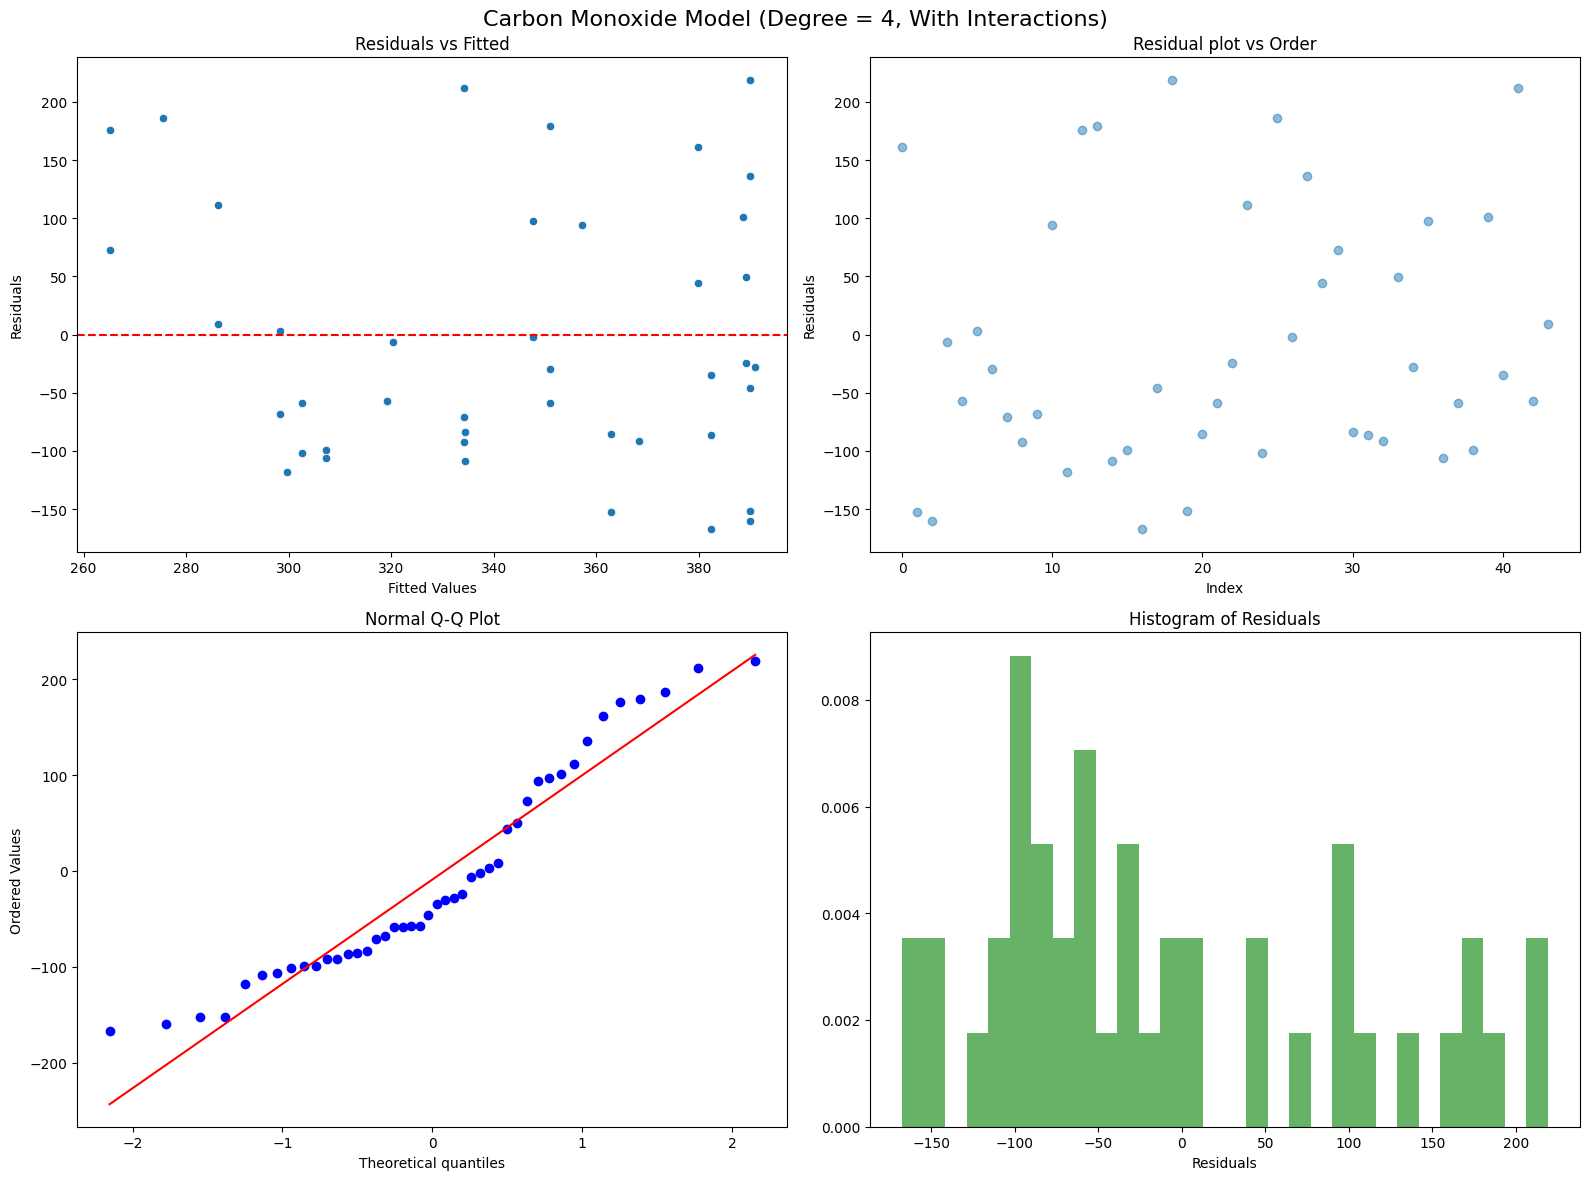

Polynominal Regression Model 3.2: Cardon Dioxide (with added interaction/dummy variables)
Cardon Dioxide Model (Degree = 4, With Interactions) - Mean Squared Error: 279.57
Cardon Dioxide Model (Degree = 4, With Interactions) - R2: 0.010099999606609344


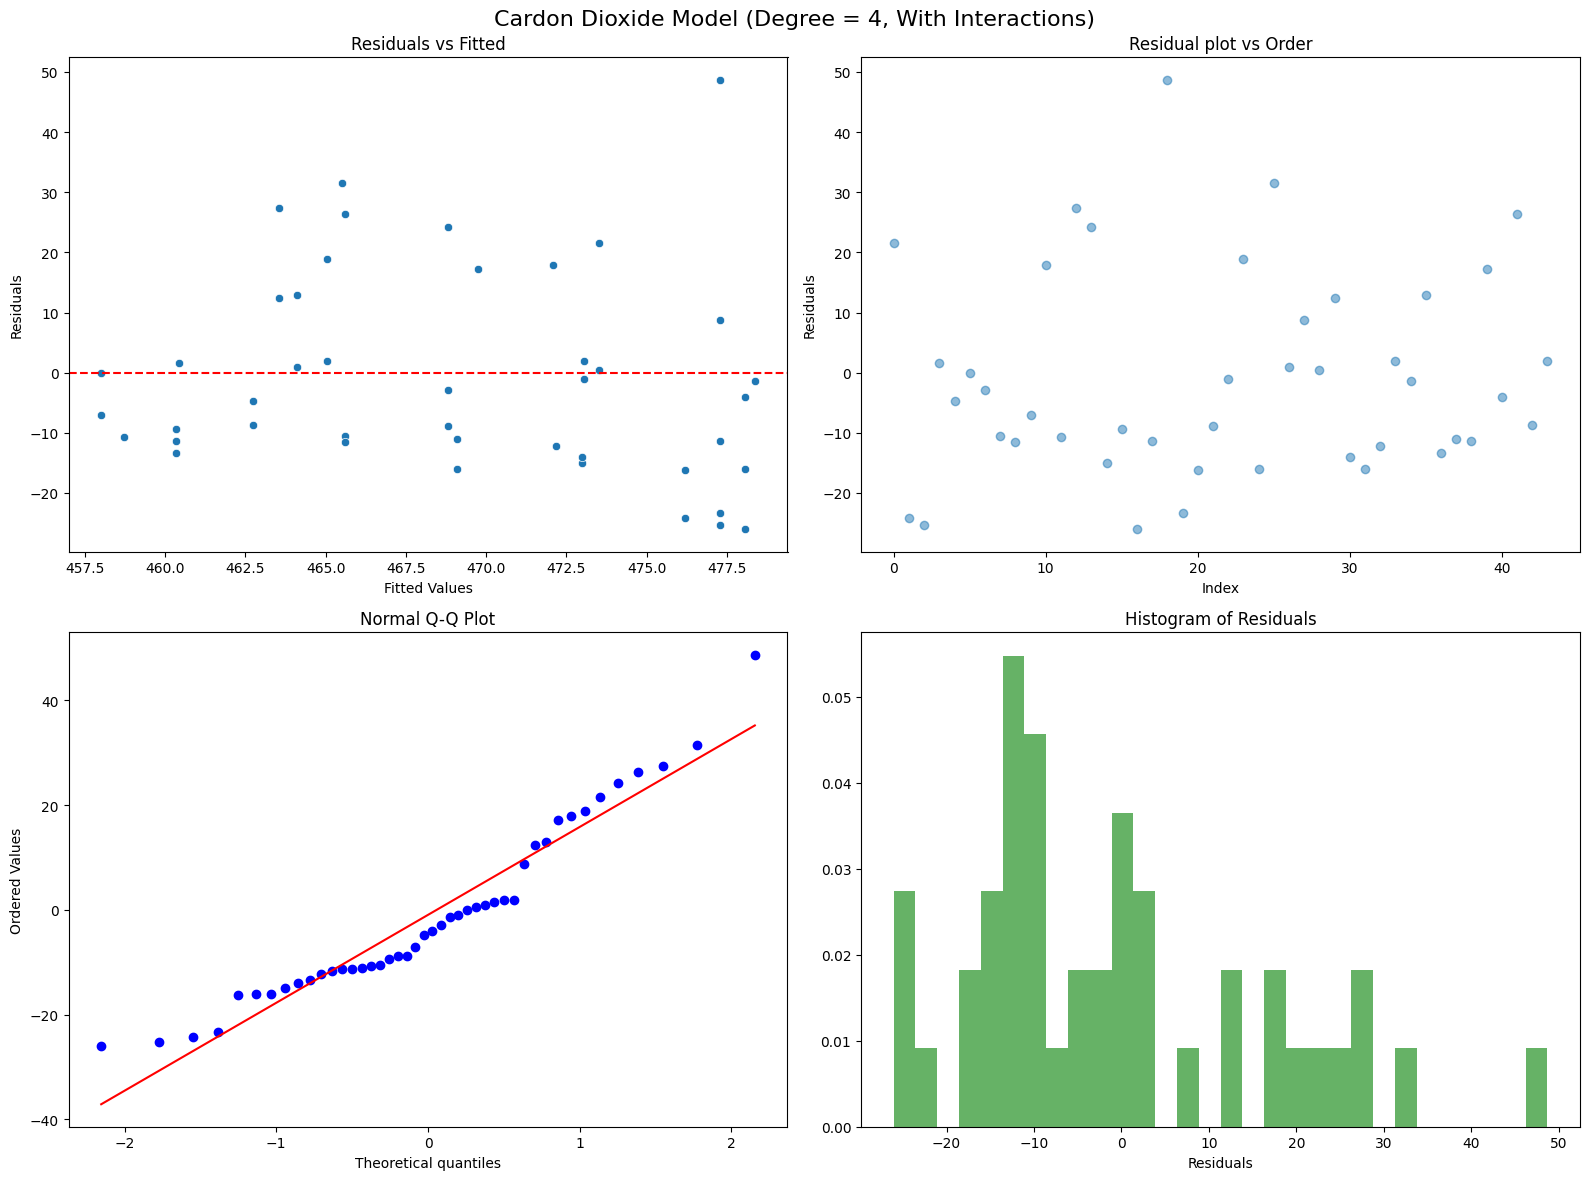

In [19]:
# Main function to answer the question
def poly_two_main():
    """
    Returns:
        Evaluated models for second polynomial regression model for each feature along with the graphs
    """
    df = preprocess_data(hourly_dataframe)

    # Model 1: Ozone
    print("Polynominal Regression Model 1: Ozone (with added interaction/dummy variables)")
    y_ozone = df['ozone']
    evaluate_model(X_poly, y_ozone, "Ozone Model (Degree = 4, With Interactions)")

    # Model 2.1: Particulate Matter 10
    print("Polynominal Regression Model 2.1: Particulate Matter 10 (with added interaction/dummy variables)")
    y_pm10 = df['pm10']
    evaluate_model(X_poly, y_pm10, "Particulate Matter 10 Model (Degree = 4, With Interactions)")

    # Model 2.2: Particulate Matter 2.5
    print("Polynominal Regression Model 2.2: Particulate Matter 2.5 (with added interaction/dummy variables)")
    y_pm2_5 = df['pm2_5']
    evaluate_model(X_poly, y_pm2_5, "Particulate Matter 2.5 (Degree = 4, With Interactions)")

    # Model 3.1: Carbon Monoxide
    print("Polynominal Regression Model 3.1: Carbon Monoxide (with added interaction/dummy variables)")
    y_carbonm = df['carbon_monoxide']
    evaluate_model(X_poly, y_carbonm, "Carbon Monoxide Model (Degree = 4, With Interactions)")

    # Model 3.2: Carbon Dioxide
    print("Polynominal Regression Model 3.2: Cardon Dioxide (with added interaction/dummy variables)")
    y_carbond = df['carbon_dioxide']
    evaluate_model(X_poly, y_carbond, "Cardon Dioxide Model (Degree = 4, With Interactions)")

# Run the main function
if __name__ == '__main__':
    poly_two_main()

## Part 2
(2%) A discussion of the preliminary results:
   - This may include checking of assumptions, generated plots/tables, measures of fit, or other attributes of the analysis
   - It does not have to be fully correct, but as a proof of concept must demonstrate that the group is close to completing the analysis
   - Discuss some of the potential ethical considerations (or explain why there aren't any) for your project

## Initial Approach
The initial question we proposed for Machine Learning part is "Can we predict air quality indicators (ozone, particulate matter, and carbon emissions) based on the hour of the day in Boston?", and after further discussions and analysis, we identified we can try building the models based on a Linear Regression for 5 air quality indicators separately and a Polynomial Regression for one of the indicators. However, as we moved forward in with the Linear Regression analysis, we got unexpectedly negative $R^2$ values for all 5 indicators (ranging from -0.069 to -0.151). This made us reconsider our initial attempt and go with Polynomial Regression for one of the indicators (Ozone). After constructing the model equation and using cross-validation, we received values of $MSE$ = 462.327 and $R^2$ = 0.0257, which showed better results, compared to Linear Regression. We decided to further improve our model by incorporating interactions with dummy variables (day/night categorization), which had values of 1 and 0. Building the polynomial regression model with interactions and dummy variables has slightly improved the $MSE$ = 432.993 and $R^2$ = 0.0104. However, the $R^2$ value was slightly lower than the second polynomial regression model's value. Moreover, we will use the Polynomial Regression model with interactions to discuss the preliminary results.

## Model 1
First, we analyzed Model 1: Ozone of Polynomial Regression with interaction terms model. We calculated $MSE$ = 432.993 and $R^2$ = 0.0104, where MSE value is lower than for the other polynomial regression models and $R^2$ value is slightly lower than the second polynomial regression model. Based on the first plot of Residuals vs Fitted, we can see that the assumption of Linearity and Constant Variance is contradicted as the residuals do not follow a linear trend about 0 and also has multiple outliers. The second plot of Residuals vs Order shows that there is some density of the data points near the y = 0 with mutliple outliers as well, indicating there might be a violation of Independence assumption as well. Looking at the Histogram of Residuals and Q-q plot, we can witness there is strong right-skewedness, showing that there is no normal distribution, meaning violation of Normality assumption.

## Model 2
For Model 2, we examined Particulate Matter using our polynomial regression model with interaction terms (dummy variables).For PM10, we calculated $MSE$ = 122.559 and $R^2$ = -0.1708. For PM2.5, we calcuated $MSE$ = 109.98 and $R^2$ = -0.1452. Both values showed negative $R^2$ values even after expanding the model to ploynomial terms. These calculations shows and confirms that hour-of-day alone does not predict accurate PM levels. The Residuals vs Fitted plot shows scatter without a trend but with inconsistency. The Residuals vs Order suggests weak independance because PM levels depend on external environment factors such as wind, humidity, etc. The Q-q plots and histograms show deviations from nomality where both models have skewed distribution.

## Model 3
For Model 3, we examined Carbon Monoxide and Carbon Dioxide using our polynomial regression model. For Carbon Monoxide, we calculated $MSE$ = 15802.879 and $R^2$ = -0.0738. For Carbon Dioxide, we calcuated $MSE$ = 369.704 and $R^2$ = -0.0647. Both carbon measurements produced negative $R^2$ values and showed large variance due to the large scale of measurements. For both models, the Residual patterns were showing significant spread and several outliers. The Q-q plots showed right-skewing, and the Histograms were irregular which shows that both carbon caluclations are not suited for hour based regression.

## Conclusions
The findings from our models reveal the limitations of using a the hour of day as a predictor. While our polynomial regression model with interaction terms did show slight improvement, the constantly poor performance across all models with the best R^2 value reaching only 0.0104 expose the critical weaknesses in our modeling approach.

Because there were violations of assumptions in all models, it hints that the problem at hand is more complex than what the models can handle. For instance, some of the changes in the models can have correlations to the current season that the model doesn't take into account. Because there are violations in all the models, it indicates that the problems we are trying to model aren't as simple as we think. The model can't handle the complexities of the problems at hand.

Additionally, in all models, the residuals featured irregular outliers and high spread in the values. This means that the models were overall poor fits for accurately predicting the data. This heterosceddasticity can be observed for instance in the Carbon Dioxide model. These instances of violations of our assumptions all suggest that the model can't keep up with the complexity of the data.

This is especially telling when looking at the R^2 values. For all of our models, the highest R^2 value calculated was .0104. This was a pretty big sign that our models didn't work too well with the data. Taking into consideration that our highest value was under 2%, this means that over 98% of the variation in our data couldn't be explained and 2 of our models had negative R^2 values. Some of this variability can be explained by factors such as the season, irregular changes in climate, and global warming.

